
KNN Performance:
  R^2 Score:           0.7835
  Mean Squared Error:  988.9952
  Mean Absolute Error: 22.8554
  PHM08 Score (sum):   1698235.6139
  PHM08 Score (avg):   411.4940

MLP Performance:
  R^2 Score:           0.7456
  Mean Squared Error:  1162.2813
  Mean Absolute Error: 24.0844
  PHM08 Score (sum):   1889258.0366
  PHM08 Score (avg):   457.7800

Ensemble Performance:
  R^2 Score:           0.7905
  Mean Squared Error:  956.9582
  Mean Absolute Error: 21.9874
  PHM08 Score (sum):   854443.8411
  PHM08 Score (avg):   207.0375
Computing SHAP (fast mode) for KNN...


  0%|          | 0/200 [00:00<?, ?it/s]

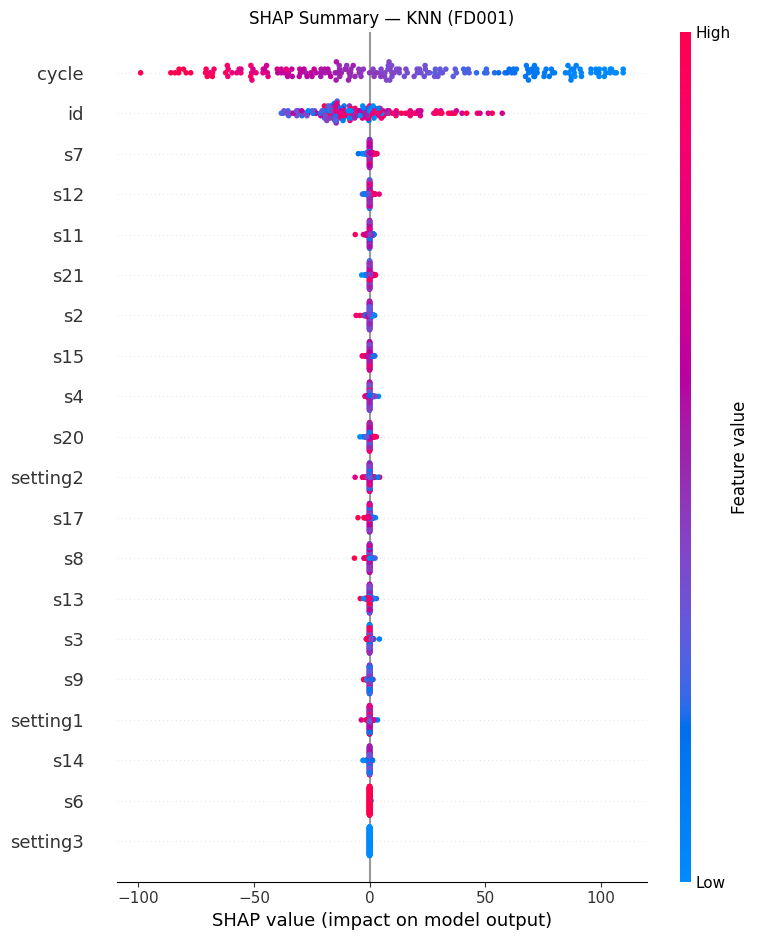

  0%|          | 0/1 [00:00<?, ?it/s]

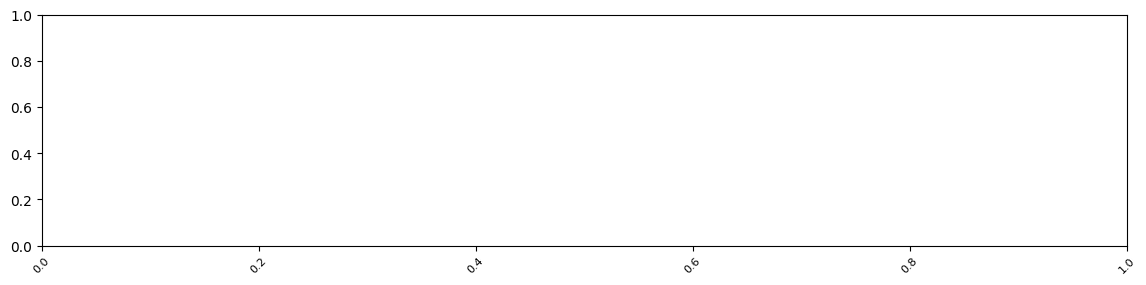

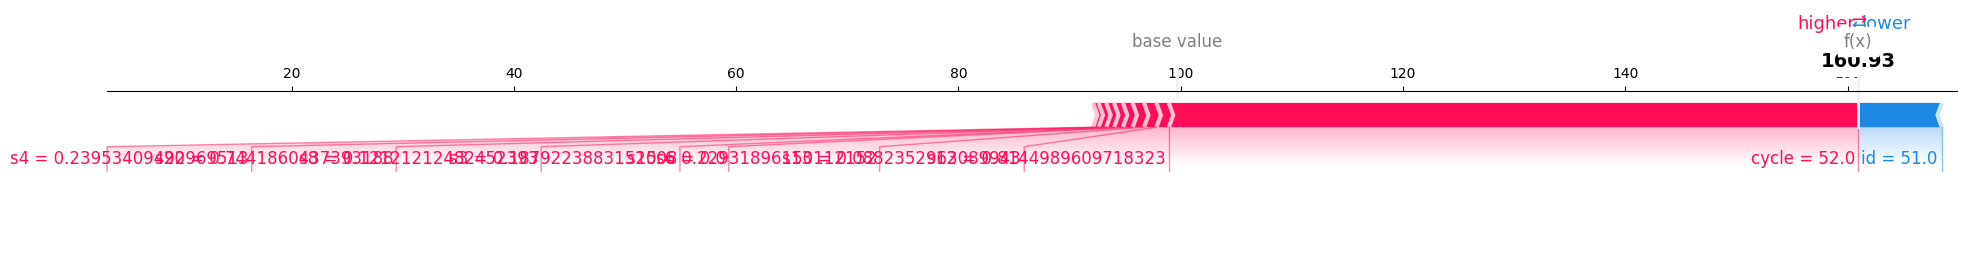

[INFO] KNN SHAP exceeded time cap.
Computing SHAP (fast mode) for MLP...


  0%|          | 0/200 [00:00<?, ?it/s]

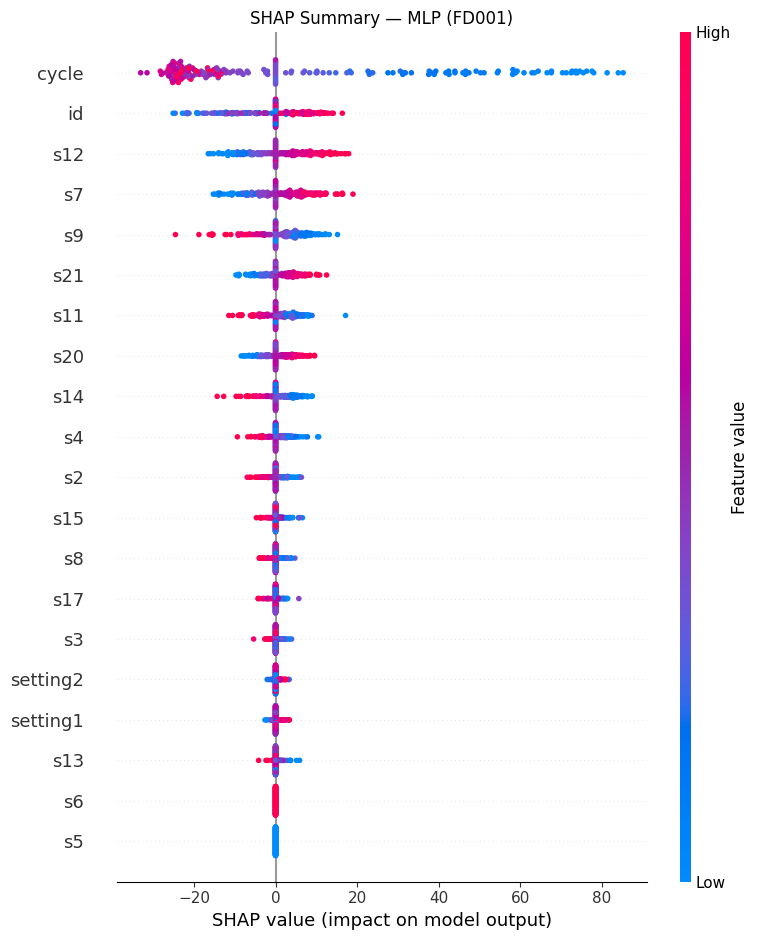

  0%|          | 0/1 [00:00<?, ?it/s]

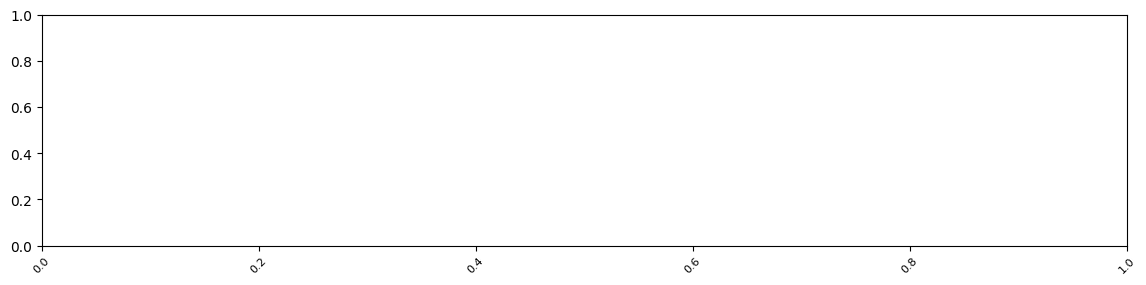

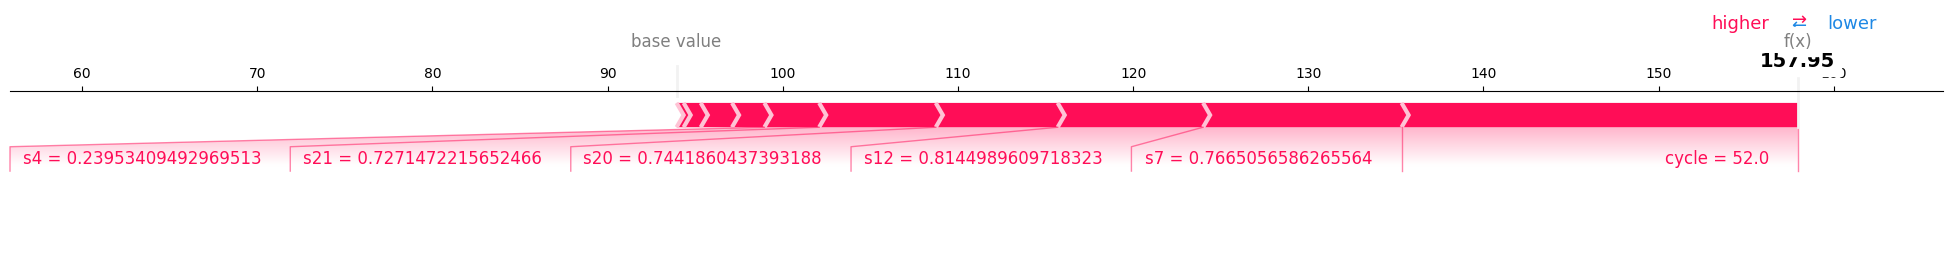

Plotting SHAP summary (Ensemble)...


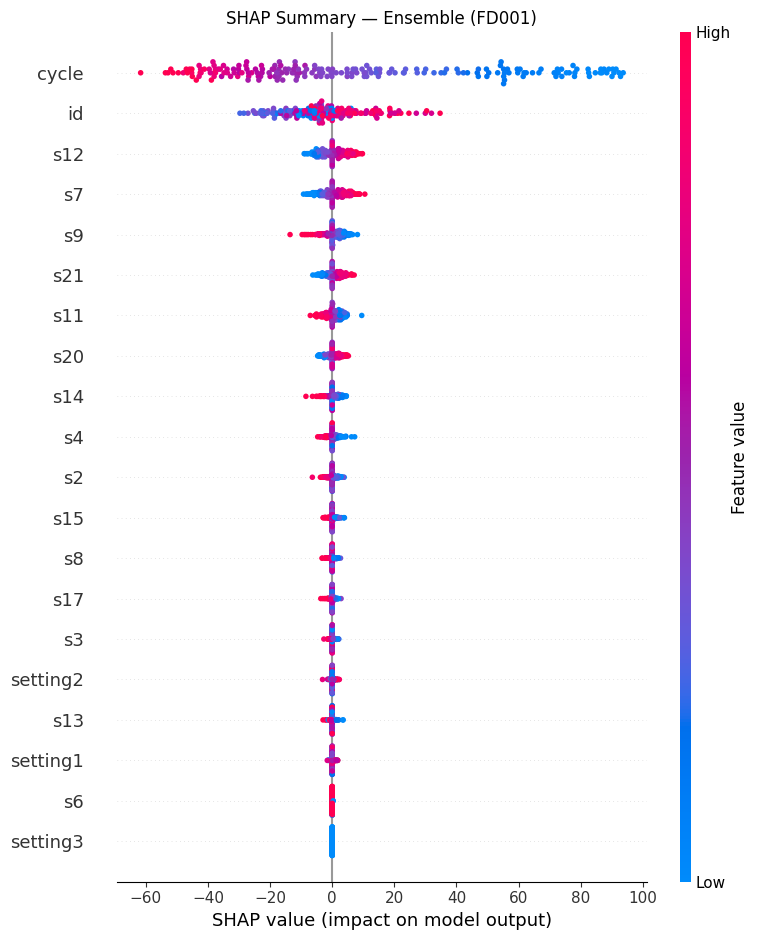

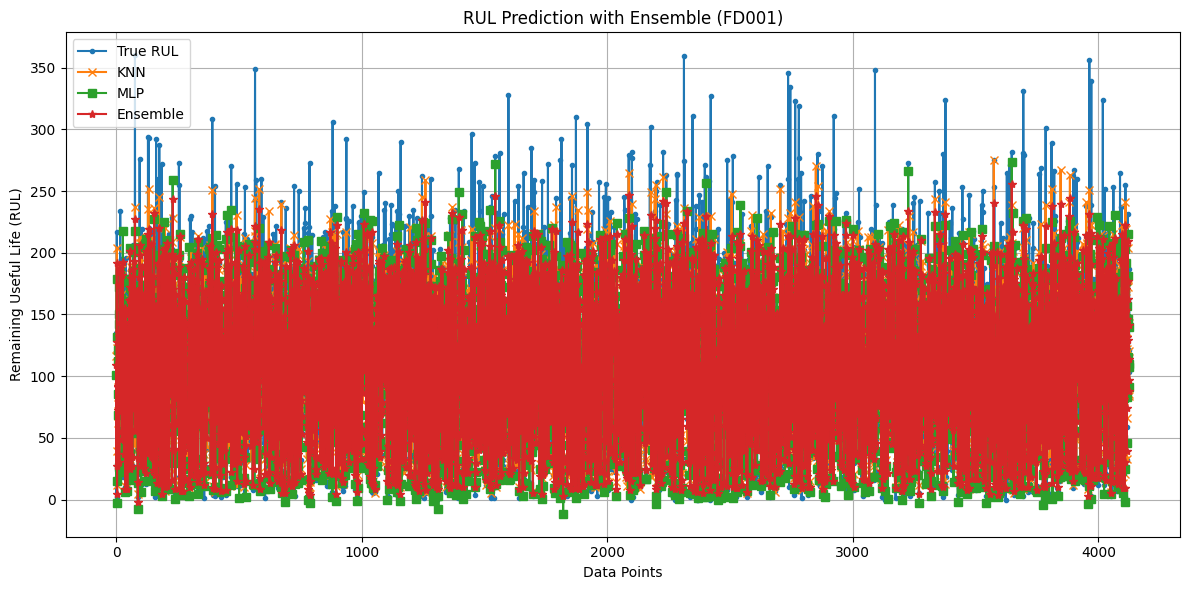



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (KNN) ---
Fold1: R2=0.6369, RMSE=42.6587, MAE=29.9188, PHM08_sum=64925163.4816, PHM08_avg=15758.5348
Fold2: R2=0.6634, RMSE=40.1871, MAE=27.9753, PHM08_sum=8098136.7327, PHM08_avg=1959.3846
Fold3: R2=0.6994, RMSE=37.8045, MAE=25.8402, PHM08_sum=11701732.8551, PHM08_avg=2836.0962
Fold4: R2=0.6296, RMSE=41.3558, MAE=30.4620, PHM08_sum=5377803.7839, PHM08_avg=1303.7100
Fold5: R2=0.6202, RMSE=41.5225, MAE=30.5339, PHM08_sum=28489287.9885, PHM08_avg=6903.1471
Overall: R2=0.6502, RMSE=40.7384, MAE=28.9454, PHM08_sum=118592124.8418, PHM08_avg=5748.2490

--- GroupKFold (MLP) ---
Fold1: R2=0.5659, RMSE=46.6450, MAE=33.0328, PHM08_sum=13951053.8973, PHM08_avg=3386.1781
Fold2: R2=0.6161, RMSE=42.9188, MAE=29.3260, PHM08_sum=14699817.8949, PHM08_avg=3556.6944
Fold3

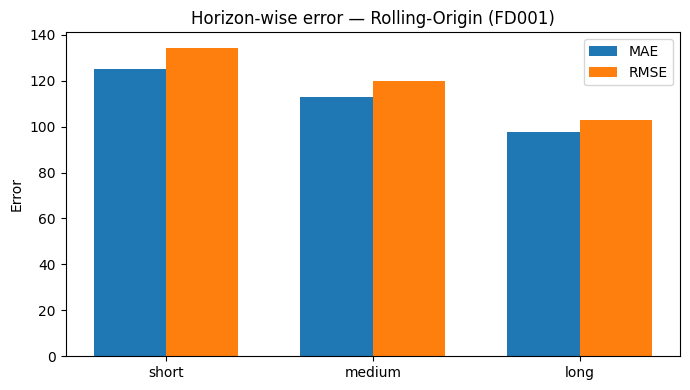

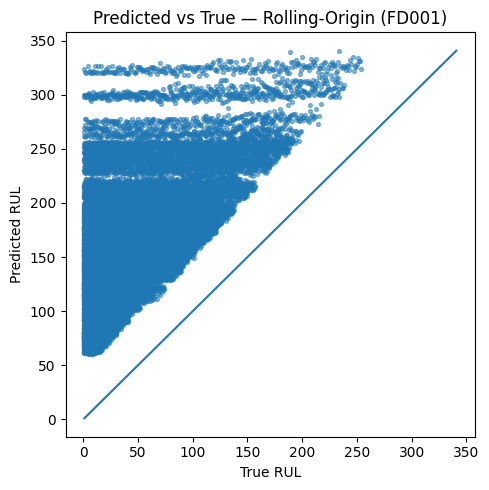


[PER-ENGINE MAE] (Top 10 worst engines)
69    166.043318
92    154.974261
96    152.848120
67    147.972328
83    139.887692
56    138.322226
86    137.674953
64    137.577740
2     136.337082
95    134.835129
dtype: float64


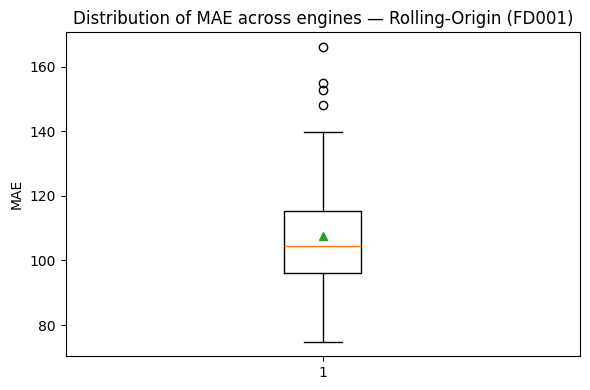

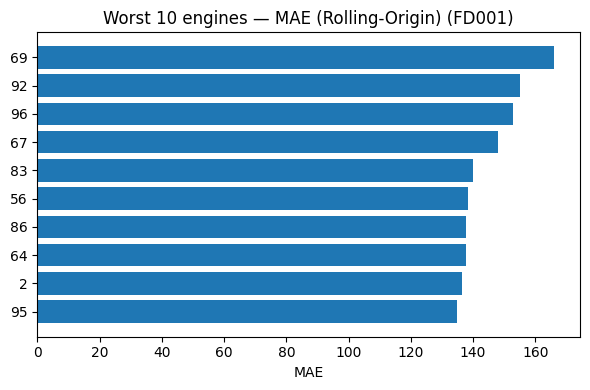


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -7.4990
    RMSE: 120.5633
     MAE: 112.6858
 sMAPE_%: 112.9774

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.6499 ± 0.0286
Without id/cycle : R²=0.5917 ± 0.0344


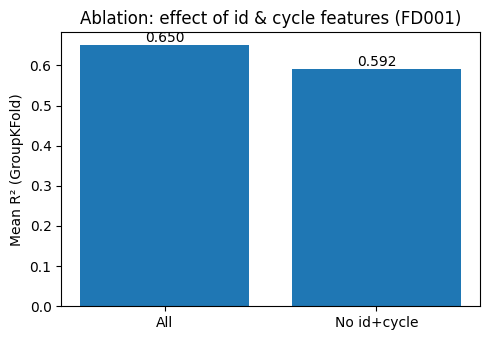


================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 20631
Train (80%)   : 16504  → ratio=0.8000
Test  (20%)   : 4127  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 1023.10 seconds
CPU% at start        : 16.4%   (~0.43 GHz)
CPU% at end          : 15.7%   (~0.41 GHz)
Memory at start      : 371.30 MB
Memory at end        : 443.57 MB   (Δ 72.27 MB)


In [2]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD001"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "knnmlp"

# Fixed model hyperparameters (as requested)
KNN_PARAMS = dict(
    n_neighbors=14,
    weights='uniform',
    metric='manhattan'
)

MLP_PARAMS = dict(
    hidden_layer_sizes=(50, 50, 50),
    activation='relu',
    solver='adam',
    alpha=0.01,
    learning_rate='constant',
    max_iter=500,
    random_state=42
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

warnings.filterwarnings("ignore")

# ============================================
# Output paths — single, unified directory
# ============================================
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# ============================================
# Model training (KNN + MLP) and ensemble
# ============================================
knn_model = KNeighborsRegressor(**KNN_PARAMS)
knn_model.fit(X_train, y_train)
y_knn = knn_model.predict(X_val)

mlp_model = MLPRegressor(**MLP_PARAMS)
mlp_model.fit(X_train, y_train)
y_mlp = mlp_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_knn + 0.5 * y_mlp

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_knn = print_block_metrics("KNN",         y_val, y_knn)
m_mlp = print_block_metrics("MLP",         y_val, y_mlp)
m_ens = print_block_metrics("Ensemble",    y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_knn, m_mlp, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations — KernelExplainer (model-agnostic)
# ============================================
# To keep runtime reasonable, we subsample background and explanation sets.
SHAP_MAX_SECS = 120
BG_KMEANS_K   = 25
EXPL_SAMPLES  = 200
NSAMPLES      = 100
L1_REG        = "num_features(10)"

bg_size   = min(1000, X_train.shape[0])
shap_size = min(EXPL_SAMPLES, X_val.shape[0])

X_bg_df   = X_train.sample(n=bg_size, random_state=42)
X_shap_df = X_val.sample(n=shap_size, random_state=42)

X_bg_np   = X_bg_df.to_numpy(dtype=np.float32)
X_shap_np = X_shap_df.to_numpy(dtype=np.float32)
feature_names = X.columns.tolist()

# Summarize background with k-means for performance
try:
    km_obj = shap.kmeans(X_bg_np, BG_KMEANS_K)
    X_bg_km = km_obj.data if hasattr(km_obj, "data") else np.array(km_obj)
except Exception as e:
    print(f"[WARN] kmeans background failed: {e}; using raw background.")
    X_bg_km = X_bg_np

def fast_kernel_shap(model, X_background_np, X_explain_np, X_explain_df, title_prefix, file_tag):
    import time as _time
    t0 = _time.time()

    # Ensure DenseData is converted to ndarray before prediction
    def predict_fn(A):
        if hasattr(A, "data"):
            A = A.data
        return model.predict(np.asarray(A, dtype=np.float32))

    try:
        explainer = shap.KernelExplainer(predict_fn, X_background_np, link="identity")
        shap_vals = explainer.shap_values(
            X_explain_np, nsamples=NSAMPLES, l1_reg=L1_REG
        )
        shap_vals = np.asarray(shap_vals)

        shap.summary_plot(shap_vals, X_explain_df, feature_names=feature_names, show=False)
        plt.title(f"SHAP Summary — {title_prefix} ({DATASET_NAME})")
        plt.tight_layout()
        save_png(f"SHAP_Summary_{file_tag}_{DATASET_NAME}.png")
        plt.show()

        row_np  = X_explain_np[[0]]
        sv_row  = np.asarray(explainer.shap_values(row_np, nsamples=NSAMPLES, l1_reg=L1_REG))[0]
        expected_val = float(np.mean(predict_fn(X_background_np)))
        fig, ax = plt.subplots(figsize=(14, 3))
        _ = shap.force_plot(expected_val, sv_row, row_np[0],
                            feature_names=feature_names, matplotlib=True, show=False)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        plt.tight_layout()
        save_png(f"Local_SHAP_force_{file_tag}_Single_{DATASET_NAME}.png")
        plt.show()

        if (_time.time() - t0) > SHAP_MAX_SECS:
            print(f"[INFO] {title_prefix} SHAP exceeded time cap.")

        return shap_vals

    except Exception as e:
        print(f"[WARN] {title_prefix} SHAP failed: {e}")
        return None

print("Computing SHAP (fast mode) for KNN...")
shap_vals_knn = fast_kernel_shap(knn_model, X_bg_km, X_shap_np, X_shap_df, "KNN", "KNN")

print("Computing SHAP (fast mode) for MLP...")
shap_vals_mlp = fast_kernel_shap(mlp_model, X_bg_km, X_shap_np, X_shap_df, "MLP", "MLP")

if (shap_vals_knn is not None) and (shap_vals_mlp is not None) and \
   (np.shape(shap_vals_knn) == np.shape(shap_vals_mlp)):
    shap_vals_ens = (np.asarray(shap_vals_knn) + np.asarray(shap_vals_mlp)) / 2.0
    print("Plotting SHAP summary (Ensemble)...")
    shap.summary_plot(shap_vals_ens, X_shap_df, feature_names=feature_names, show=False)
    plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] Ensemble SHAP skipped (inputs unavailable or shape mismatch).")

# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_knn)),      y_knn,          label="KNN",       marker='x')
plt.plot(range(len(y_mlp)),      y_mlp,          label="MLP",       marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",  marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

# Config & helpers
W = 30
H = 1
EMBARGO = 10
N_SPLITS = 5

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaling
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_knn = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", KNeighborsRegressor(**KNN_PARAMS))
])
pipe_mlp = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", MLPRegressor(**MLP_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
_ = cv_eval_pipeline(X, y, groups, pipe_knn, name="KNN")
_ = cv_eval_pipeline(X, y, groups, pipe_mlp, name="MLP")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_knn():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", KNeighborsRegressor(**KNN_PARAMS))
    ])

def build_pipe_mlp():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", MLPRegressor(**MLP_PARAMS))
    ])

_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_knn, name="KNN"
)
_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_mlp, name="MLP"
)

# ============================================
# A/B leakage diagnostics
# ============================================
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", KNeighborsRegressor(**KNN_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", KNeighborsRegressor(**KNN_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_knn, name="KNN")
_ = cv_eval_pipeline(X, y, groups, build_pipe_knn(), name="KNN (GroupKFold)")

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_knn,
    embargo_val=0,  name=f"Rolling-Origin KNN (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_knn,
    embargo_val=10, name=f"Rolling-Origin KNN (Embargo=10, {DATASET_NAME})"
)

# ============================================
# Permutation (Null) Test
# ============================================
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_knn, n_iters=1
)

# ============================================
# Horizon-wise error profile & plots
# ============================================
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_knn
)

if hy is not None:
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": horizon_bins(pd.Series(hy))})
    met = (dfm.groupby("bin", dropna=False)
             .apply(lambda g: pd.Series({
                 "MAE": mean_absolute_error(g["y"], g["p"]),
                 "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
                 "R2": r2_score(g["y"], g["p"])
             }))
          ).reset_index()
    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met)); w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    lo = float(min(np.min(hy), np.min(hp))); hi = float(max(np.max(hy), np.max(hp)))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# ============================================
# Per-engine error distribution
# ============================================
def rolling_origin_engine_errors(df_all, features, model_builder):
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_knn
)

if per_engine:
    mae_series = pd.Series(
        {eid: np.mean(v) for eid, v in per_engine.items()}
    ).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# ============================================
# sMAPE + overall rolling-origin metrics
# ============================================
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# ============================================
# Ablation: effect of including id & cycle
# ============================================
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_knn)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_knn)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")



KNN Performance:
  R^2 Score:           0.6792
  Mean Squared Error:  1505.4054
  Mean Absolute Error: 29.8027
  PHM08 Score (sum):   7948264.3850
  PHM08 Score (avg):   739.2359

MLP Performance:
  R^2 Score:           0.7204
  Mean Squared Error:  1312.2290
  Mean Absolute Error: 26.7283
  PHM08 Score (sum):   6108751.5922
  PHM08 Score (avg):   568.1503

Ensemble Performance:
  R^2 Score:           0.7274
  Mean Squared Error:  1279.2927
  Mean Absolute Error: 26.7790
  PHM08 Score (sum):   4118516.0615
  PHM08 Score (avg):   383.0465
Computing SHAP (fast mode) for KNN...


  0%|          | 0/200 [00:00<?, ?it/s]

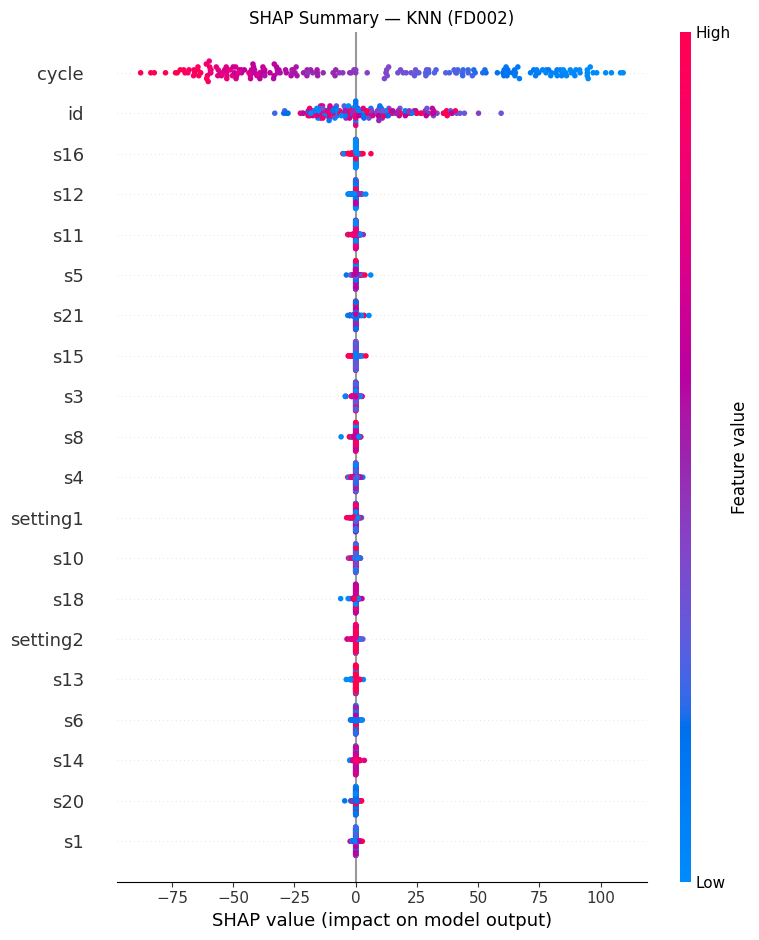

  0%|          | 0/1 [00:00<?, ?it/s]

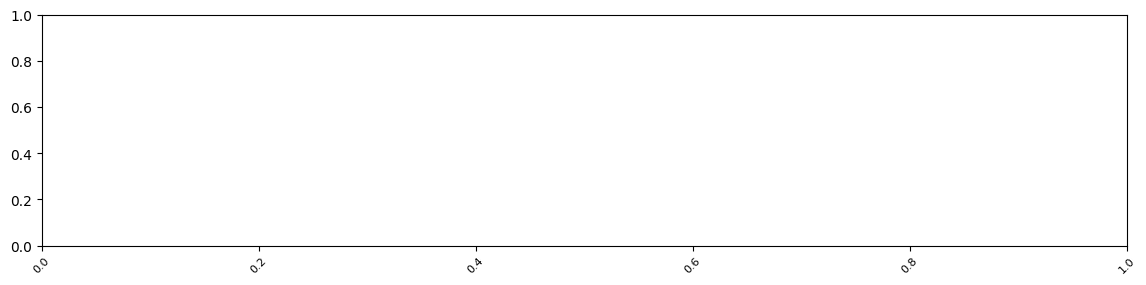

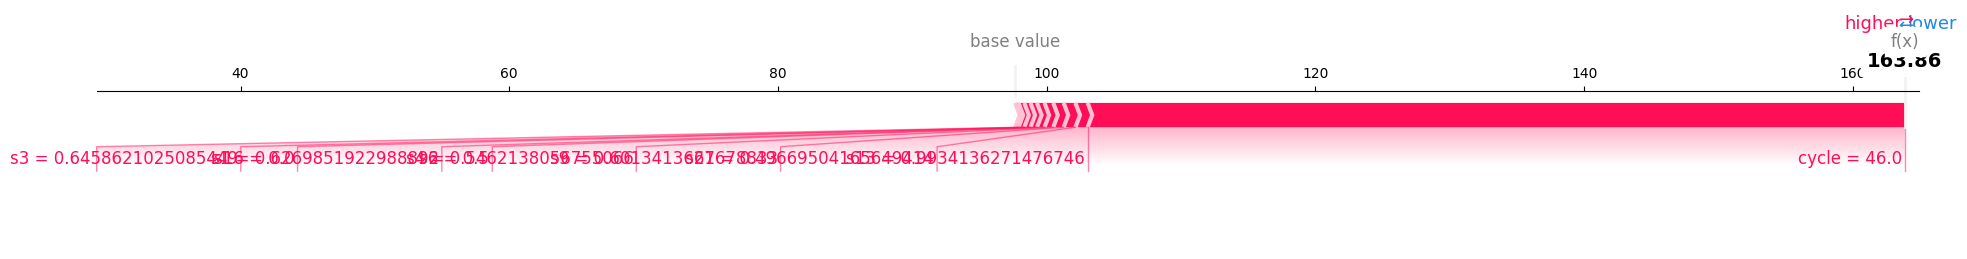

[INFO] KNN SHAP exceeded time cap.
Computing SHAP (fast mode) for MLP...


  0%|          | 0/200 [00:00<?, ?it/s]

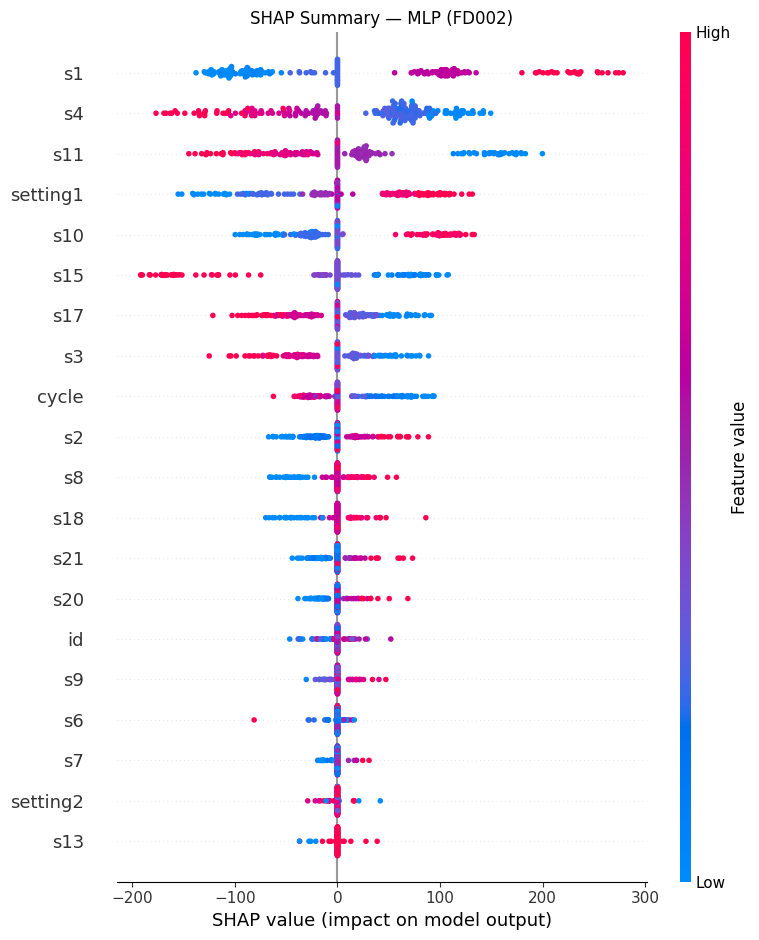

  0%|          | 0/1 [00:00<?, ?it/s]

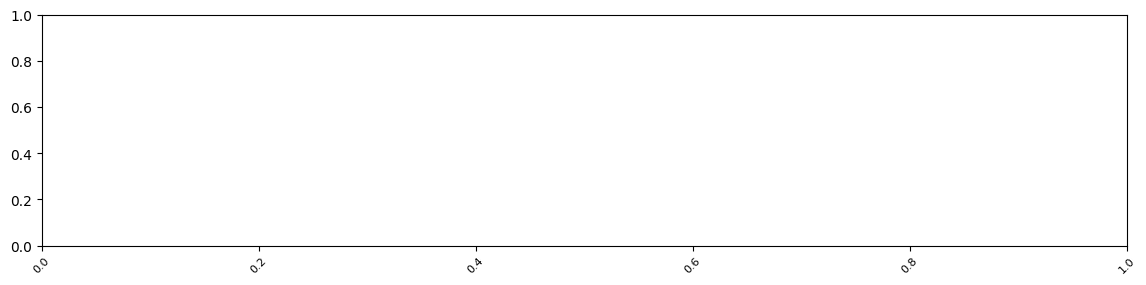

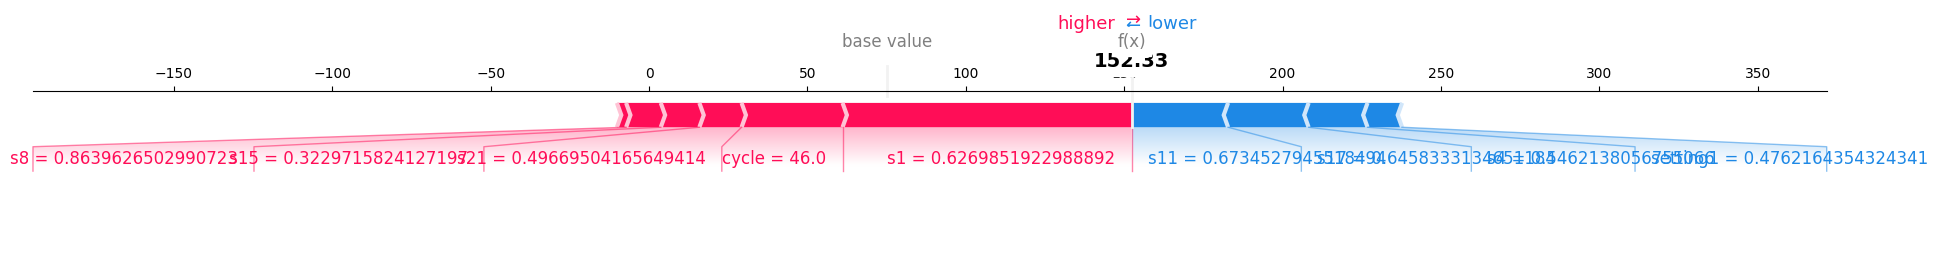

Plotting SHAP summary (Ensemble)...


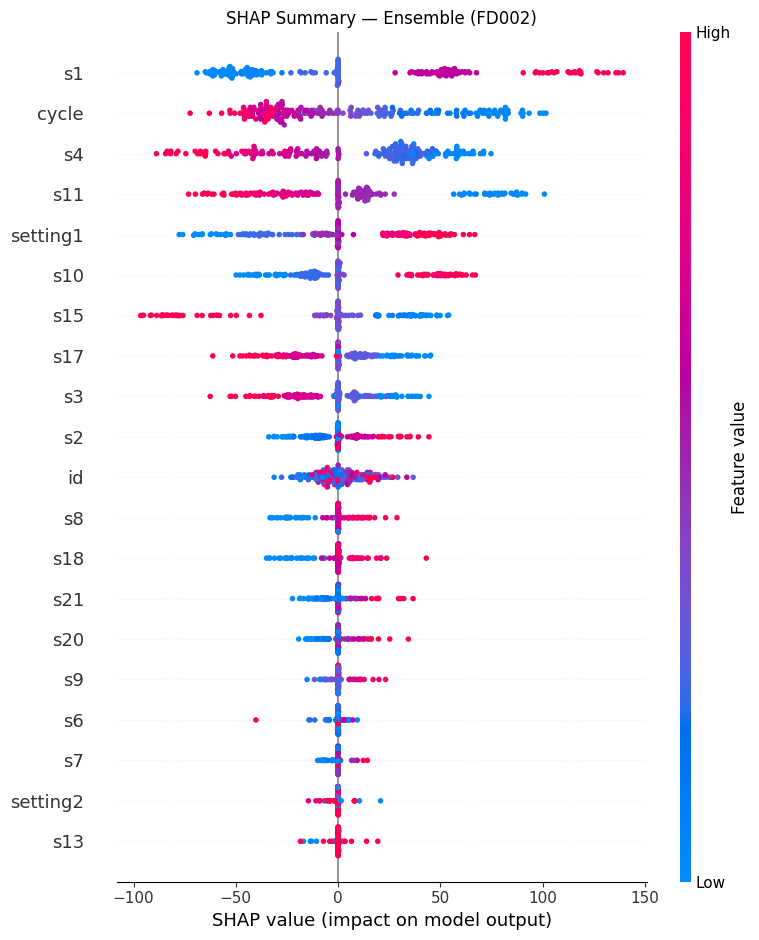

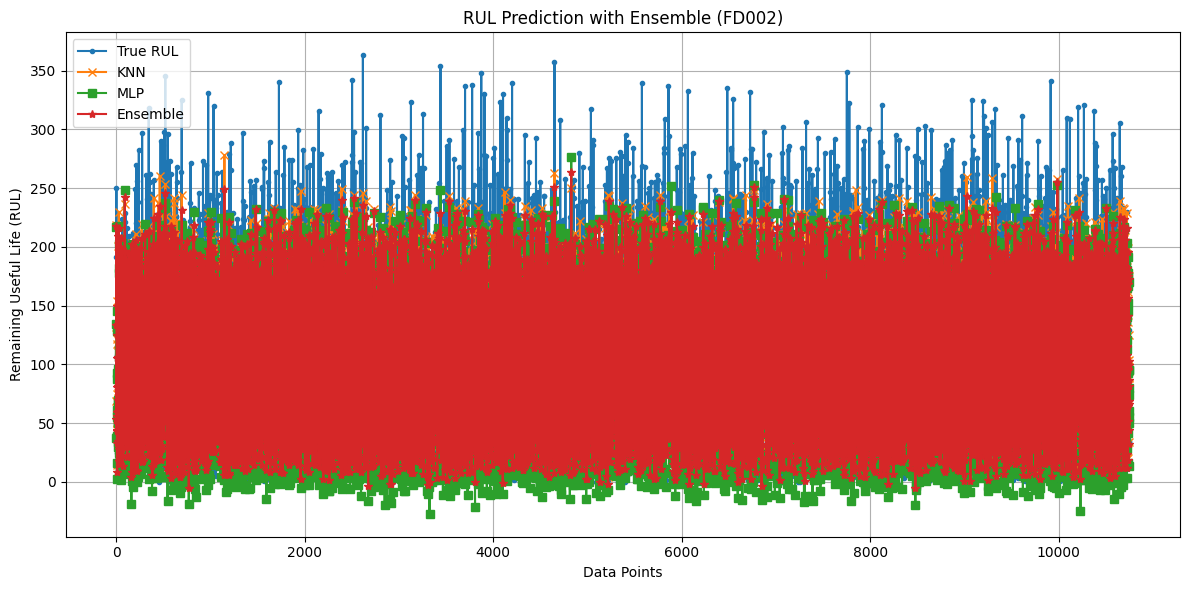



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (KNN) ---
Fold1: R2=0.6525, RMSE=41.0224, MAE=30.3486, PHM08_sum=22713103.3578, PHM08_avg=2111.8646
Fold2: R2=0.6457, RMSE=41.2466, MAE=31.0436, PHM08_sum=28245560.4398, PHM08_avg=2627.7384
Fold3: R2=0.6879, RMSE=38.4989, MAE=28.1343, PHM08_sum=9045041.2339, PHM08_avg=841.1644
Fold4: R2=0.6407, RMSE=41.3065, MAE=31.3955, PHM08_sum=16880757.9323, PHM08_avg=1569.8650
Fold5: R2=0.6491, RMSE=40.9773, MAE=30.2179, PHM08_sum=15310445.9573, PHM08_avg=1424.3600
Overall: R2=0.6552, RMSE=40.6242, MAE=30.2279, PHM08_sum=92194908.9209, PHM08_avg=1714.9670

--- GroupKFold (MLP) ---
Fold1: R2=0.6900, RMSE=38.7491, MAE=27.4135, PHM08_sum=47710296.6053, PHM08_avg=4436.1038
Fold2: R2=0.7177, RMSE=36.8204, MAE=28.3330, PHM08_sum=4421727.9134, PHM08_avg=411.3618
Fold3: R2

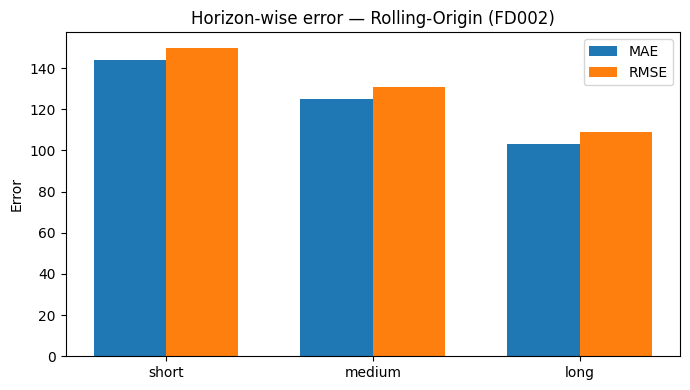

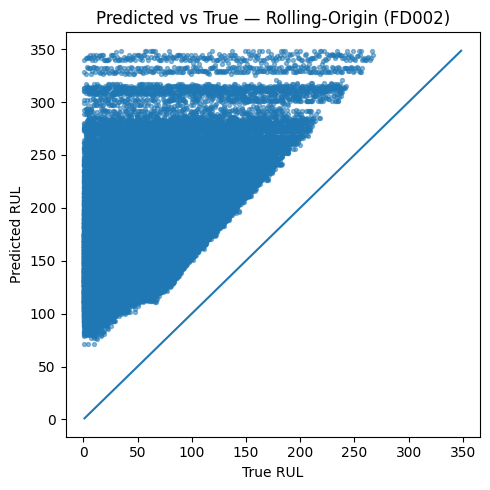


[PER-ENGINE MAE] (Top 10 worst engines)
112    192.805701
88     184.556984
85     180.637288
118    177.769015
31     176.635396
255    175.944760
260    165.437736
257    162.887458
158    162.310867
94     161.074230
dtype: float64


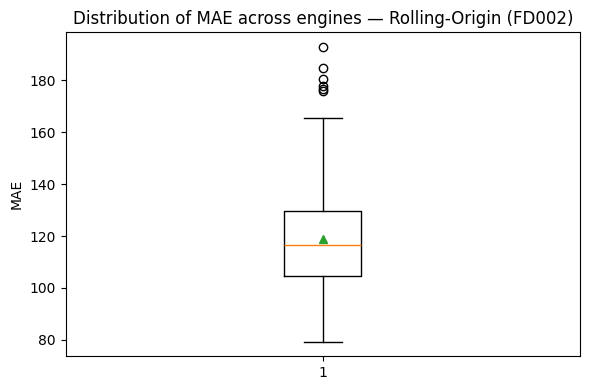

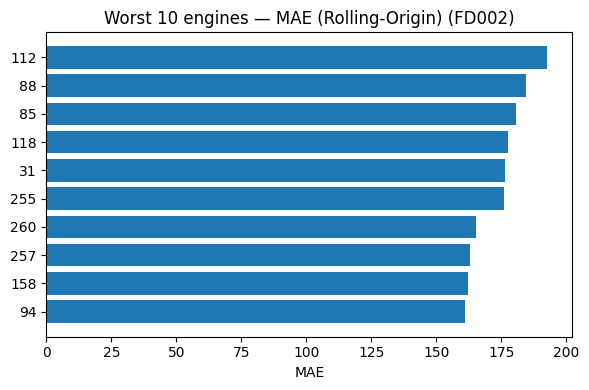


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -9.0875
    RMSE: 132.0337
     MAE: 125.2368
 sMAPE_%: 117.4856

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.6552 ± 0.0168
Without id/cycle : R²=0.5740 ± 0.0306


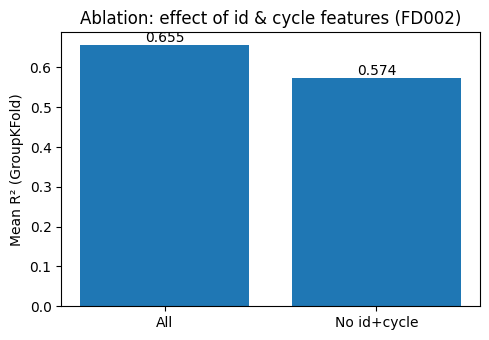


================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 53759
Train (80%)   : 43007  → ratio=0.8000
Test  (20%)   : 10752  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 1569.42 seconds
CPU% at start        : 3.0%   (~0.08 GHz)
CPU% at end          : 17.4%   (~0.45 GHz)
Memory at start      : 443.83 MB
Memory at end        : 594.70 MB   (Δ 150.87 MB)


In [3]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD002"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "knnmlp"

# Fixed model hyperparameters (as requested)
KNN_PARAMS = dict(
    n_neighbors=14,
    weights='uniform',
    metric='manhattan'
)

MLP_PARAMS = dict(
    hidden_layer_sizes=(50, 50, 50),
    activation='relu',
    solver='adam',
    alpha=0.01,
    learning_rate='constant',
    max_iter=500,
    random_state=42
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

warnings.filterwarnings("ignore")

# ============================================
# Output paths — single, unified directory
# ============================================
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# ============================================
# Model training (KNN + MLP) and ensemble
# ============================================
knn_model = KNeighborsRegressor(**KNN_PARAMS)
knn_model.fit(X_train, y_train)
y_knn = knn_model.predict(X_val)

mlp_model = MLPRegressor(**MLP_PARAMS)
mlp_model.fit(X_train, y_train)
y_mlp = mlp_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_knn + 0.5 * y_mlp

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_knn = print_block_metrics("KNN",         y_val, y_knn)
m_mlp = print_block_metrics("MLP",         y_val, y_mlp)
m_ens = print_block_metrics("Ensemble",    y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_knn, m_mlp, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations — KernelExplainer (model-agnostic)
# ============================================
# To keep runtime reasonable, we subsample background and explanation sets.
SHAP_MAX_SECS = 120
BG_KMEANS_K   = 25
EXPL_SAMPLES  = 200
NSAMPLES      = 100
L1_REG        = "num_features(10)"

bg_size   = min(1000, X_train.shape[0])
shap_size = min(EXPL_SAMPLES, X_val.shape[0])

X_bg_df   = X_train.sample(n=bg_size, random_state=42)
X_shap_df = X_val.sample(n=shap_size, random_state=42)

X_bg_np   = X_bg_df.to_numpy(dtype=np.float32)
X_shap_np = X_shap_df.to_numpy(dtype=np.float32)
feature_names = X.columns.tolist()

# Summarize background with k-means for performance
try:
    km_obj = shap.kmeans(X_bg_np, BG_KMEANS_K)
    X_bg_km = km_obj.data if hasattr(km_obj, "data") else np.array(km_obj)
except Exception as e:
    print(f"[WARN] kmeans background failed: {e}; using raw background.")
    X_bg_km = X_bg_np

def fast_kernel_shap(model, X_background_np, X_explain_np, X_explain_df, title_prefix, file_tag):
    import time as _time
    t0 = _time.time()

    # Ensure DenseData is converted to ndarray before prediction
    def predict_fn(A):
        if hasattr(A, "data"):
            A = A.data
        return model.predict(np.asarray(A, dtype=np.float32))

    try:
        explainer = shap.KernelExplainer(predict_fn, X_background_np, link="identity")
        shap_vals = explainer.shap_values(
            X_explain_np, nsamples=NSAMPLES, l1_reg=L1_REG
        )
        shap_vals = np.asarray(shap_vals)

        shap.summary_plot(shap_vals, X_explain_df, feature_names=feature_names, show=False)
        plt.title(f"SHAP Summary — {title_prefix} ({DATASET_NAME})")
        plt.tight_layout()
        save_png(f"SHAP_Summary_{file_tag}_{DATASET_NAME}.png")
        plt.show()

        row_np  = X_explain_np[[0]]
        sv_row  = np.asarray(explainer.shap_values(row_np, nsamples=NSAMPLES, l1_reg=L1_REG))[0]
        expected_val = float(np.mean(predict_fn(X_background_np)))
        fig, ax = plt.subplots(figsize=(14, 3))
        _ = shap.force_plot(expected_val, sv_row, row_np[0],
                            feature_names=feature_names, matplotlib=True, show=False)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        plt.tight_layout()
        save_png(f"Local_SHAP_force_{file_tag}_Single_{DATASET_NAME}.png")
        plt.show()

        if (_time.time() - t0) > SHAP_MAX_SECS:
            print(f"[INFO] {title_prefix} SHAP exceeded time cap.")

        return shap_vals

    except Exception as e:
        print(f"[WARN] {title_prefix} SHAP failed: {e}")
        return None

print("Computing SHAP (fast mode) for KNN...")
shap_vals_knn = fast_kernel_shap(knn_model, X_bg_km, X_shap_np, X_shap_df, "KNN", "KNN")

print("Computing SHAP (fast mode) for MLP...")
shap_vals_mlp = fast_kernel_shap(mlp_model, X_bg_km, X_shap_np, X_shap_df, "MLP", "MLP")

if (shap_vals_knn is not None) and (shap_vals_mlp is not None) and \
   (np.shape(shap_vals_knn) == np.shape(shap_vals_mlp)):
    shap_vals_ens = (np.asarray(shap_vals_knn) + np.asarray(shap_vals_mlp)) / 2.0
    print("Plotting SHAP summary (Ensemble)...")
    shap.summary_plot(shap_vals_ens, X_shap_df, feature_names=feature_names, show=False)
    plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] Ensemble SHAP skipped (inputs unavailable or shape mismatch).")

# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_knn)),      y_knn,          label="KNN",       marker='x')
plt.plot(range(len(y_mlp)),      y_mlp,          label="MLP",       marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",  marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

# Config & helpers
W = 30
H = 1
EMBARGO = 10
N_SPLITS = 5

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaling
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_knn = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", KNeighborsRegressor(**KNN_PARAMS))
])
pipe_mlp = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", MLPRegressor(**MLP_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
_ = cv_eval_pipeline(X, y, groups, pipe_knn, name="KNN")
_ = cv_eval_pipeline(X, y, groups, pipe_mlp, name="MLP")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_knn():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", KNeighborsRegressor(**KNN_PARAMS))
    ])

def build_pipe_mlp():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", MLPRegressor(**MLP_PARAMS))
    ])

_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_knn, name="KNN"
)
_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_mlp, name="MLP"
)

# ============================================
# A/B leakage diagnostics
# ============================================
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", KNeighborsRegressor(**KNN_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", KNeighborsRegressor(**KNN_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_knn, name="KNN")
_ = cv_eval_pipeline(X, y, groups, build_pipe_knn(), name="KNN (GroupKFold)")

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_knn,
    embargo_val=0,  name=f"Rolling-Origin KNN (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_knn,
    embargo_val=10, name=f"Rolling-Origin KNN (Embargo=10, {DATASET_NAME})"
)

# ============================================
# Permutation (Null) Test
# ============================================
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_knn, n_iters=1
)

# ============================================
# Horizon-wise error profile & plots
# ============================================
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_knn
)

if hy is not None:
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": horizon_bins(pd.Series(hy))})
    met = (dfm.groupby("bin", dropna=False)
             .apply(lambda g: pd.Series({
                 "MAE": mean_absolute_error(g["y"], g["p"]),
                 "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
                 "R2": r2_score(g["y"], g["p"])
             }))
          ).reset_index()
    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met)); w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    lo = float(min(np.min(hy), np.min(hp))); hi = float(max(np.max(hy), np.max(hp)))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# ============================================
# Per-engine error distribution
# ============================================
def rolling_origin_engine_errors(df_all, features, model_builder):
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_knn
)

if per_engine:
    mae_series = pd.Series(
        {eid: np.mean(v) for eid, v in per_engine.items()}
    ).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# ============================================
# sMAPE + overall rolling-origin metrics
# ============================================
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# ============================================
# Ablation: effect of including id & cycle
# ============================================
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_knn)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_knn)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")



KNN Performance:
  R^2 Score:           0.7516
  Mean Squared Error:  2434.7704
  Mean Absolute Error: 34.9633
  PHM08 Score (sum):   355087816.0901
  PHM08 Score (avg):   71821.9693

MLP Performance:
  R^2 Score:           0.8965
  Mean Squared Error:  1014.4929
  Mean Absolute Error: 20.9317
  PHM08 Score (sum):   16806783.6511
  PHM08 Score (avg):   3399.4304

Ensemble Performance:
  R^2 Score:           0.8709
  Mean Squared Error:  1265.0813
  Mean Absolute Error: 25.1465
  PHM08 Score (sum):   4841105.7735
  PHM08 Score (avg):   979.1881
Computing SHAP (fast mode) for KNN...


  0%|          | 0/200 [00:00<?, ?it/s]

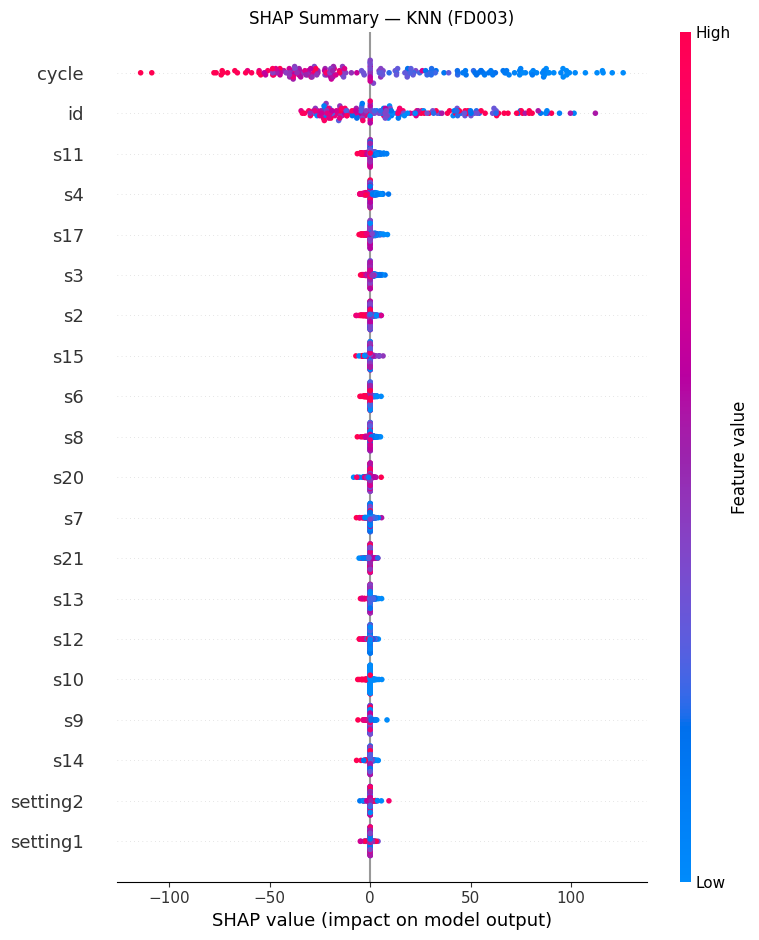

  0%|          | 0/1 [00:00<?, ?it/s]

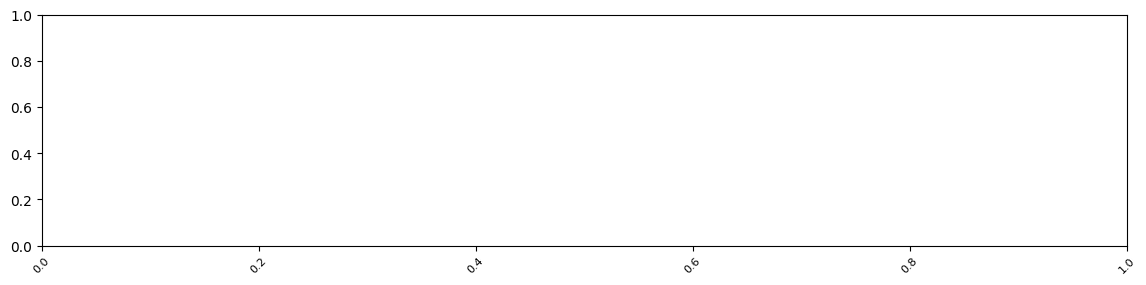

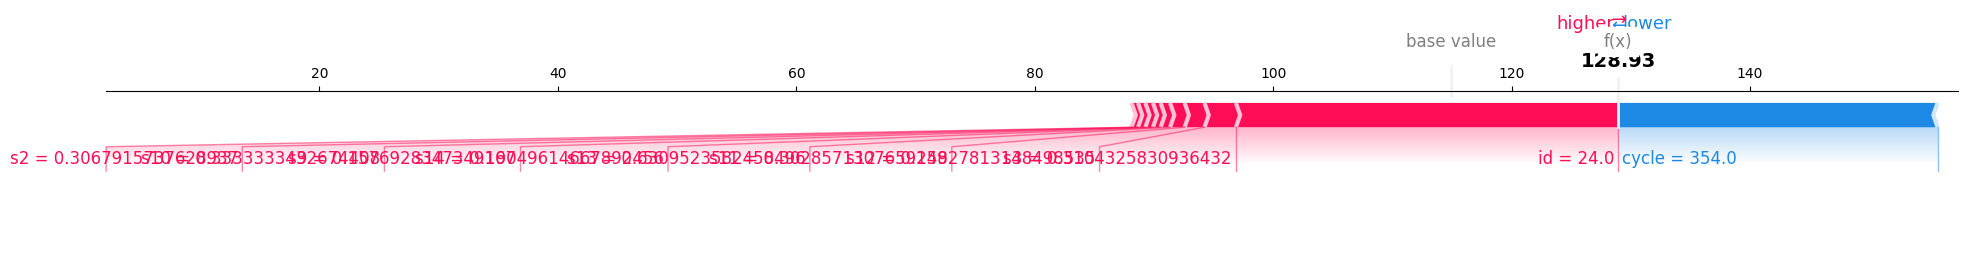

[INFO] KNN SHAP exceeded time cap.
Computing SHAP (fast mode) for MLP...


  0%|          | 0/200 [00:00<?, ?it/s]

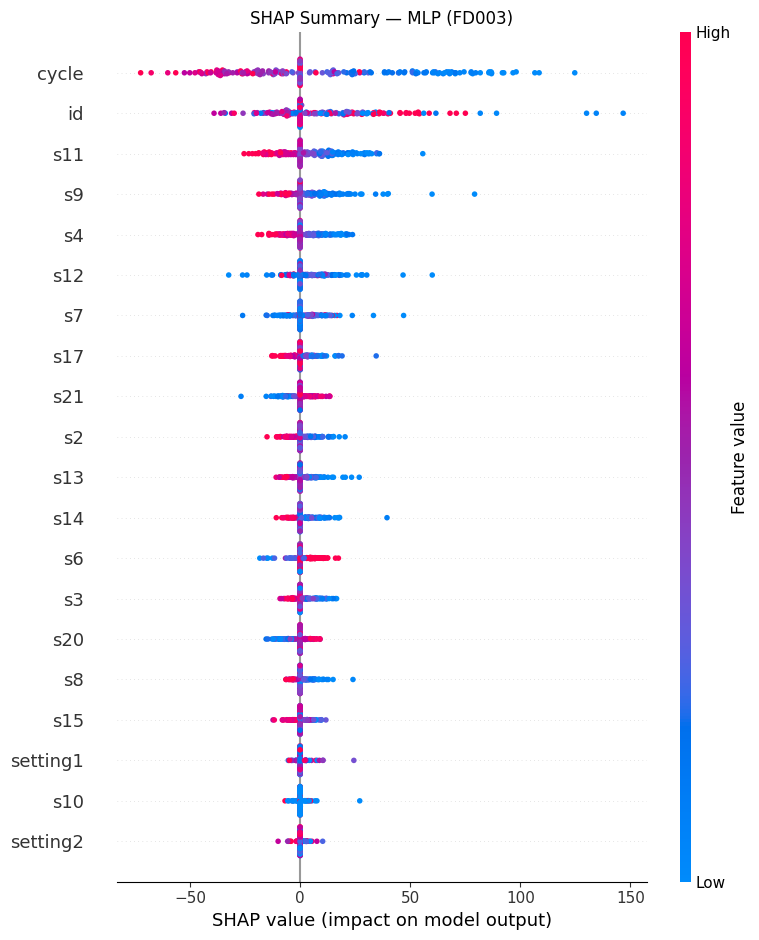

  0%|          | 0/1 [00:00<?, ?it/s]

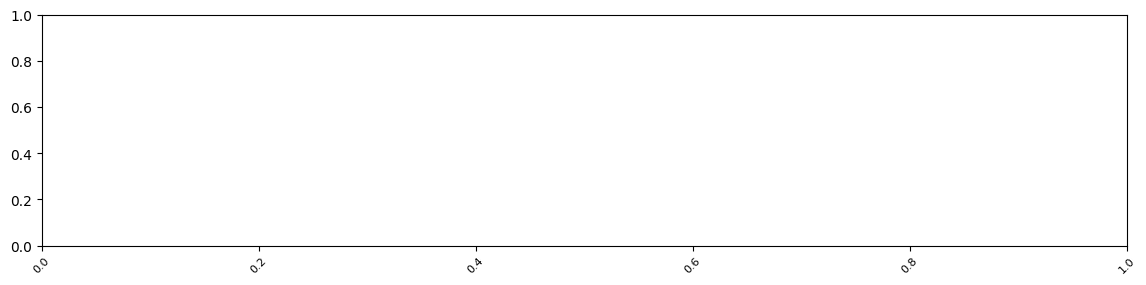

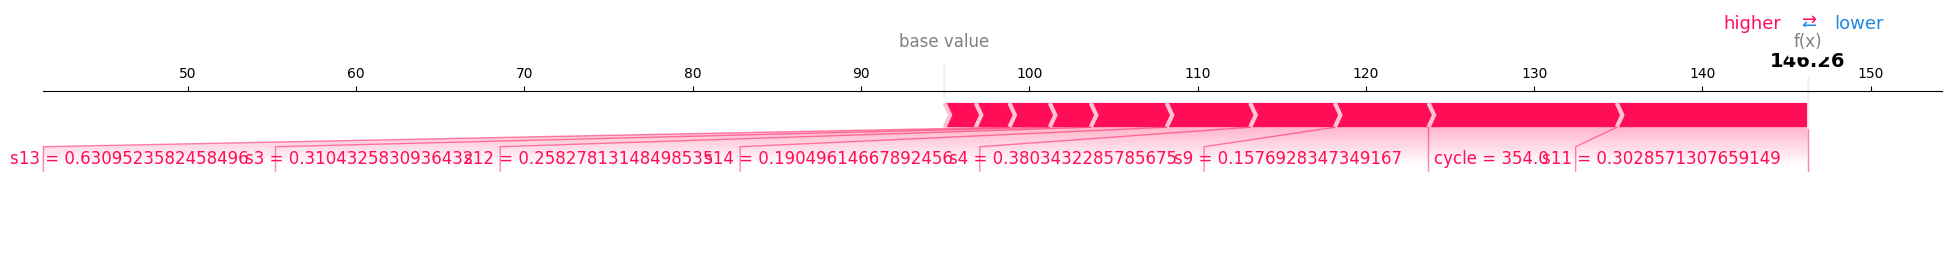

Plotting SHAP summary (Ensemble)...


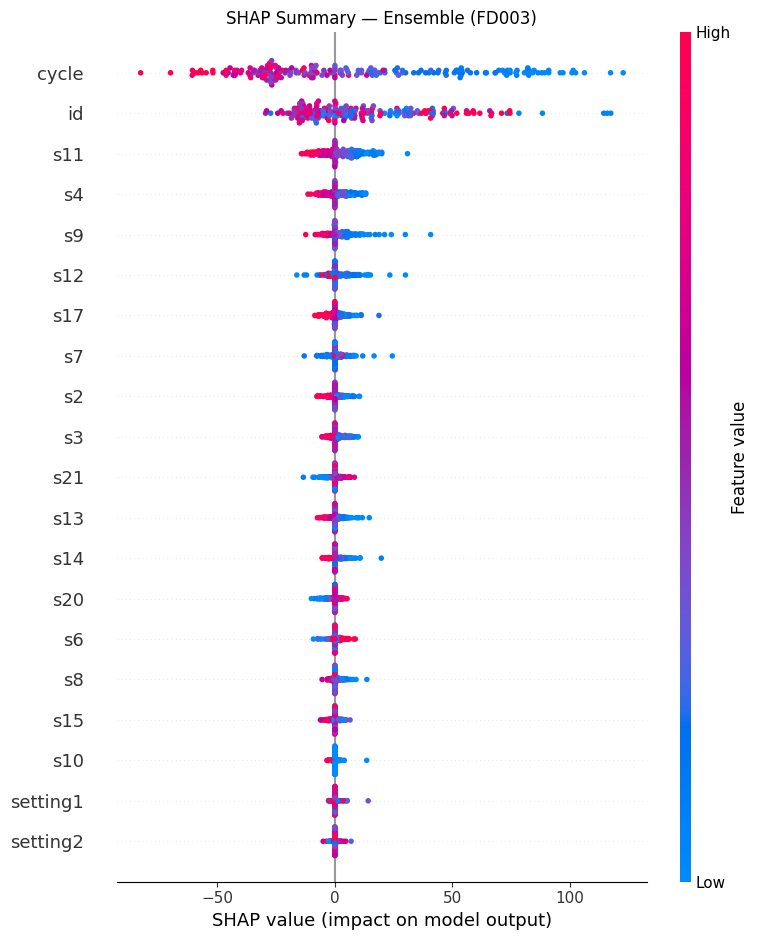

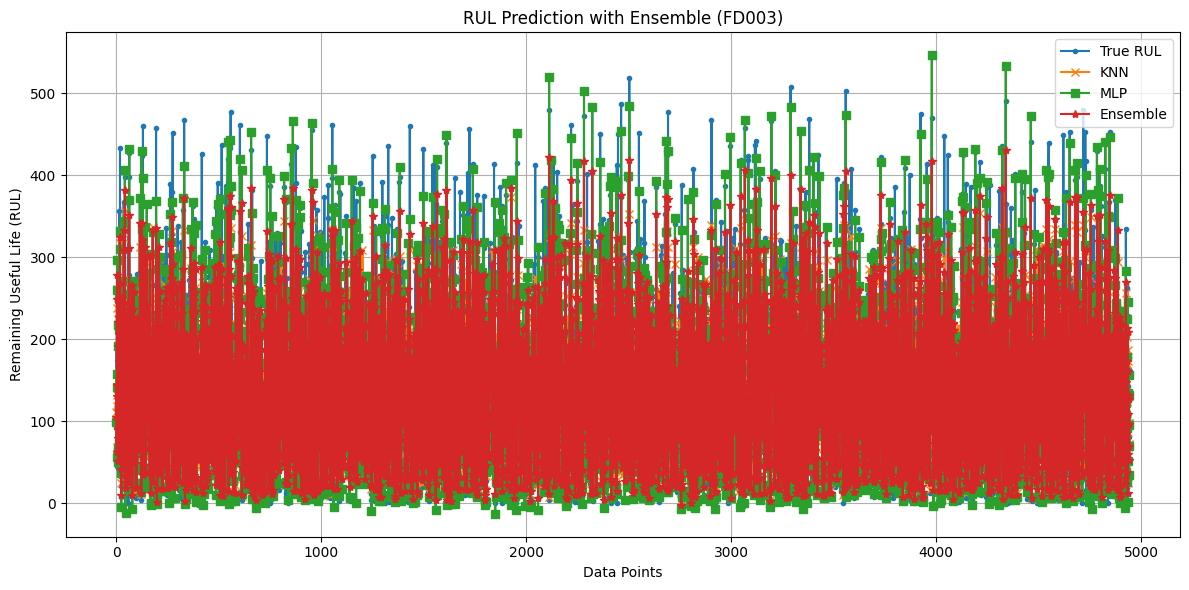



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (KNN) ---
Fold1: R2=0.5317, RMSE=69.3317, MAE=47.8699, PHM08_sum=49676420146.7768, PHM08_avg=10051885.9059
Fold2: R2=0.7011, RMSE=53.9328, MAE=35.6788, PHM08_sum=2134309785.8465, PHM08_avg=431522.3991
Fold3: R2=0.5525, RMSE=65.7858, MAE=43.2666, PHM08_sum=247373214668.8392, PHM08_avg=50014802.8041
Fold4: R2=0.6195, RMSE=60.5399, MAE=40.5392, PHM08_sum=3959560002.6351, PHM08_avg=801530.3649
Fold5: R2=0.5638, RMSE=64.5396, MAE=41.5873, PHM08_sum=51535444199366.1172, PHM08_avg=10419620743.9074
Overall: R2=0.5932, RMSE=63.0453, MAE=41.7877, PHM08_sum=51838587703970.2188, PHM08_avg=2097030246.9244

--- GroupKFold (MLP) ---
Fold1: R2=0.4661, RMSE=74.0237, MAE=47.4351, PHM08_sum=4011236262290.3823, PHM08_avg=811662537.8977
Fold2: R2=0.6860, RMSE=55.2799, MAE=3

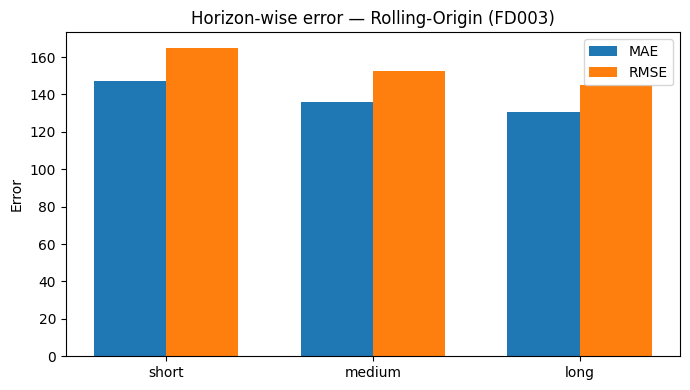

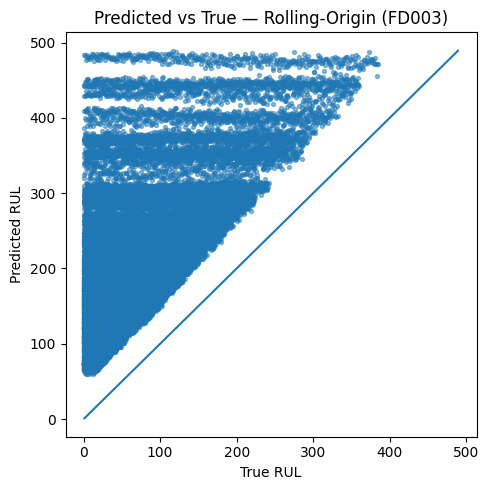


[PER-ENGINE MAE] (Top 10 worst engines)
55    219.733876
10    216.747176
96    214.997078
24    210.636408
34    197.911239
18    195.820344
7     185.677327
9     181.102012
71    180.254988
94    174.611870
dtype: float64


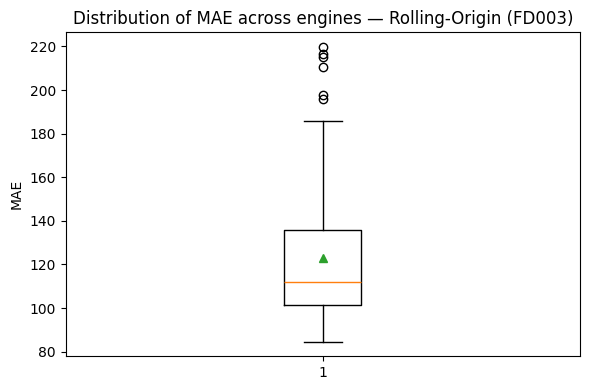

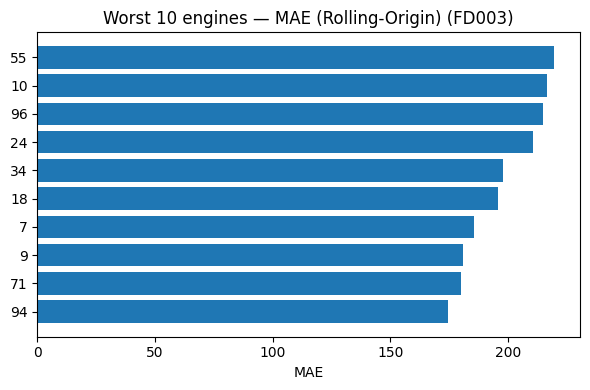


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -4.9150
    RMSE: 152.9181
     MAE: 136.7245
 sMAPE_%: 108.3669

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.5937 ± 0.0611
Without id/cycle : R²=0.5860 ± 0.0557


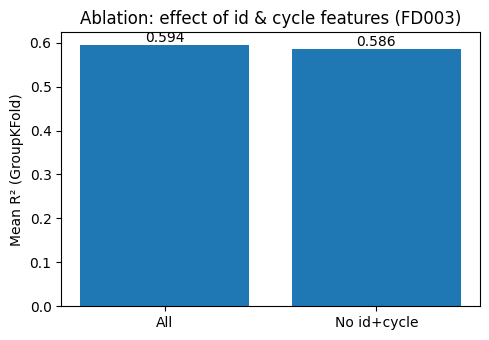


================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 24720
Train (80%)   : 19776  → ratio=0.8000
Test  (20%)   : 4944  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 1521.63 seconds
CPU% at start        : 1.7%   (~0.04 GHz)
CPU% at end          : 15.5%   (~0.40 GHz)
Memory at start      : 594.70 MB
Memory at end        : 597.45 MB   (Δ 2.75 MB)


In [4]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD003"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "knnmlp"

# Fixed model hyperparameters (as requested)
KNN_PARAMS = dict(
    n_neighbors=14,
    weights='uniform',
    metric='manhattan'
)

MLP_PARAMS = dict(
    hidden_layer_sizes=(50, 50, 50),
    activation='relu',
    solver='adam',
    alpha=0.01,
    learning_rate='constant',
    max_iter=500,
    random_state=42
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

warnings.filterwarnings("ignore")

# ============================================
# Output paths — single, unified directory
# ============================================
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# ============================================
# Model training (KNN + MLP) and ensemble
# ============================================
knn_model = KNeighborsRegressor(**KNN_PARAMS)
knn_model.fit(X_train, y_train)
y_knn = knn_model.predict(X_val)

mlp_model = MLPRegressor(**MLP_PARAMS)
mlp_model.fit(X_train, y_train)
y_mlp = mlp_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_knn + 0.5 * y_mlp

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_knn = print_block_metrics("KNN",         y_val, y_knn)
m_mlp = print_block_metrics("MLP",         y_val, y_mlp)
m_ens = print_block_metrics("Ensemble",    y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_knn, m_mlp, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations — KernelExplainer (model-agnostic)
# ============================================
# To keep runtime reasonable, we subsample background and explanation sets.
SHAP_MAX_SECS = 120
BG_KMEANS_K   = 25
EXPL_SAMPLES  = 200
NSAMPLES      = 100
L1_REG        = "num_features(10)"

bg_size   = min(1000, X_train.shape[0])
shap_size = min(EXPL_SAMPLES, X_val.shape[0])

X_bg_df   = X_train.sample(n=bg_size, random_state=42)
X_shap_df = X_val.sample(n=shap_size, random_state=42)

X_bg_np   = X_bg_df.to_numpy(dtype=np.float32)
X_shap_np = X_shap_df.to_numpy(dtype=np.float32)
feature_names = X.columns.tolist()

# Summarize background with k-means for performance
try:
    km_obj = shap.kmeans(X_bg_np, BG_KMEANS_K)
    X_bg_km = km_obj.data if hasattr(km_obj, "data") else np.array(km_obj)
except Exception as e:
    print(f"[WARN] kmeans background failed: {e}; using raw background.")
    X_bg_km = X_bg_np

def fast_kernel_shap(model, X_background_np, X_explain_np, X_explain_df, title_prefix, file_tag):
    import time as _time
    t0 = _time.time()

    # Ensure DenseData is converted to ndarray before prediction
    def predict_fn(A):
        if hasattr(A, "data"):
            A = A.data
        return model.predict(np.asarray(A, dtype=np.float32))

    try:
        explainer = shap.KernelExplainer(predict_fn, X_background_np, link="identity")
        shap_vals = explainer.shap_values(
            X_explain_np, nsamples=NSAMPLES, l1_reg=L1_REG
        )
        shap_vals = np.asarray(shap_vals)

        shap.summary_plot(shap_vals, X_explain_df, feature_names=feature_names, show=False)
        plt.title(f"SHAP Summary — {title_prefix} ({DATASET_NAME})")
        plt.tight_layout()
        save_png(f"SHAP_Summary_{file_tag}_{DATASET_NAME}.png")
        plt.show()

        row_np  = X_explain_np[[0]]
        sv_row  = np.asarray(explainer.shap_values(row_np, nsamples=NSAMPLES, l1_reg=L1_REG))[0]
        expected_val = float(np.mean(predict_fn(X_background_np)))
        fig, ax = plt.subplots(figsize=(14, 3))
        _ = shap.force_plot(expected_val, sv_row, row_np[0],
                            feature_names=feature_names, matplotlib=True, show=False)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        plt.tight_layout()
        save_png(f"Local_SHAP_force_{file_tag}_Single_{DATASET_NAME}.png")
        plt.show()

        if (_time.time() - t0) > SHAP_MAX_SECS:
            print(f"[INFO] {title_prefix} SHAP exceeded time cap.")

        return shap_vals

    except Exception as e:
        print(f"[WARN] {title_prefix} SHAP failed: {e}")
        return None

print("Computing SHAP (fast mode) for KNN...")
shap_vals_knn = fast_kernel_shap(knn_model, X_bg_km, X_shap_np, X_shap_df, "KNN", "KNN")

print("Computing SHAP (fast mode) for MLP...")
shap_vals_mlp = fast_kernel_shap(mlp_model, X_bg_km, X_shap_np, X_shap_df, "MLP", "MLP")

if (shap_vals_knn is not None) and (shap_vals_mlp is not None) and \
   (np.shape(shap_vals_knn) == np.shape(shap_vals_mlp)):
    shap_vals_ens = (np.asarray(shap_vals_knn) + np.asarray(shap_vals_mlp)) / 2.0
    print("Plotting SHAP summary (Ensemble)...")
    shap.summary_plot(shap_vals_ens, X_shap_df, feature_names=feature_names, show=False)
    plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] Ensemble SHAP skipped (inputs unavailable or shape mismatch).")

# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_knn)),      y_knn,          label="KNN",       marker='x')
plt.plot(range(len(y_mlp)),      y_mlp,          label="MLP",       marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",  marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

# Config & helpers
W = 30
H = 1
EMBARGO = 10
N_SPLITS = 5

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaling
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_knn = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", KNeighborsRegressor(**KNN_PARAMS))
])
pipe_mlp = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", MLPRegressor(**MLP_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
_ = cv_eval_pipeline(X, y, groups, pipe_knn, name="KNN")
_ = cv_eval_pipeline(X, y, groups, pipe_mlp, name="MLP")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_knn():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", KNeighborsRegressor(**KNN_PARAMS))
    ])

def build_pipe_mlp():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", MLPRegressor(**MLP_PARAMS))
    ])

_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_knn, name="KNN"
)
_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_mlp, name="MLP"
)

# ============================================
# A/B leakage diagnostics
# ============================================
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", KNeighborsRegressor(**KNN_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", KNeighborsRegressor(**KNN_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_knn, name="KNN")
_ = cv_eval_pipeline(X, y, groups, build_pipe_knn(), name="KNN (GroupKFold)")

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_knn,
    embargo_val=0,  name=f"Rolling-Origin KNN (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_knn,
    embargo_val=10, name=f"Rolling-Origin KNN (Embargo=10, {DATASET_NAME})"
)

# ============================================
# Permutation (Null) Test
# ============================================
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_knn, n_iters=1
)

# ============================================
# Horizon-wise error profile & plots
# ============================================
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_knn
)

if hy is not None:
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": horizon_bins(pd.Series(hy))})
    met = (dfm.groupby("bin", dropna=False)
             .apply(lambda g: pd.Series({
                 "MAE": mean_absolute_error(g["y"], g["p"]),
                 "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
                 "R2": r2_score(g["y"], g["p"])
             }))
          ).reset_index()
    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met)); w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    lo = float(min(np.min(hy), np.min(hp))); hi = float(max(np.max(hy), np.max(hp)))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# ============================================
# Per-engine error distribution
# ============================================
def rolling_origin_engine_errors(df_all, features, model_builder):
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_knn
)

if per_engine:
    mae_series = pd.Series(
        {eid: np.mean(v) for eid, v in per_engine.items()}
    ).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# ============================================
# sMAPE + overall rolling-origin metrics
# ============================================
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# ============================================
# Ablation: effect of including id & cycle
# ============================================
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_knn)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_knn)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")



KNN Performance:
  R^2 Score:           0.5588
  Mean Squared Error:  3547.2172
  Mean Absolute Error: 45.1766
  PHM08 Score (sum):   148700640047.1581
  PHM08 Score (avg):   12138827.7590

MLP Performance:
  R^2 Score:           0.6678
  Mean Squared Error:  2671.4407
  Mean Absolute Error: 37.8541
  PHM08 Score (sum):   78543806343.9022
  PHM08 Score (avg):   6411739.2934

Ensemble Performance:
  R^2 Score:           0.6572
  Mean Squared Error:  2756.2893
  Mean Absolute Error: 39.1690
  PHM08 Score (sum):   38022564457.0271
  PHM08 Score (avg):   3103882.8128
Computing SHAP (fast mode) for KNN...


  0%|          | 0/200 [00:00<?, ?it/s]

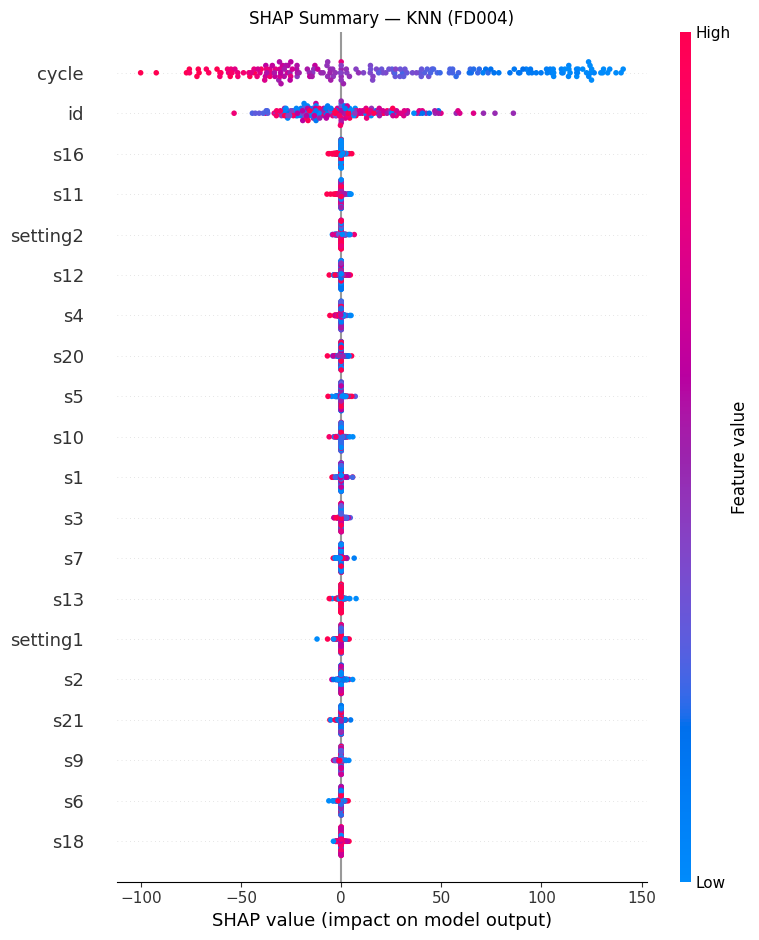

  0%|          | 0/1 [00:00<?, ?it/s]

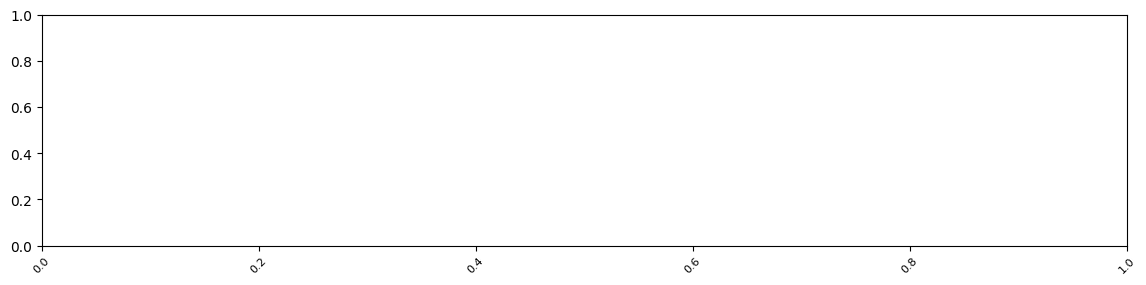

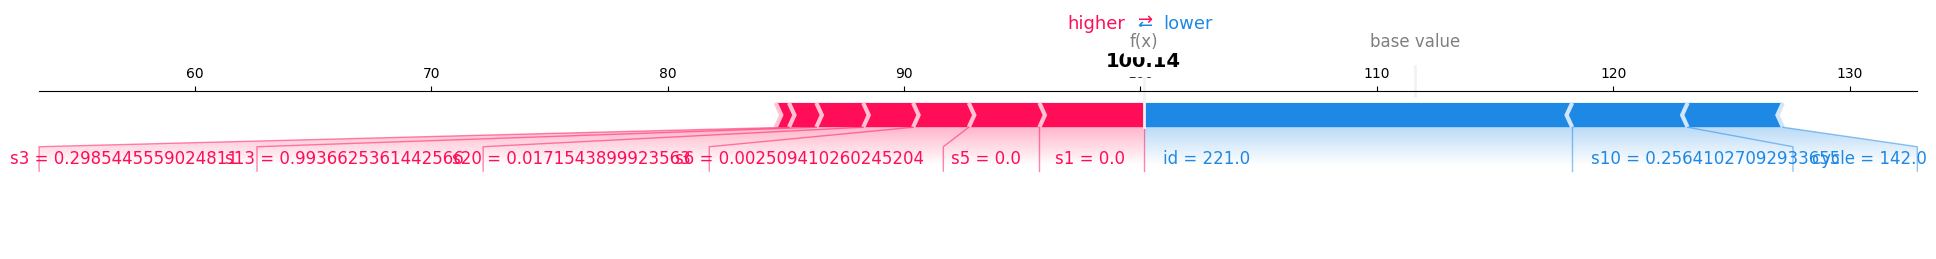

[INFO] KNN SHAP exceeded time cap.
Computing SHAP (fast mode) for MLP...


  0%|          | 0/200 [00:00<?, ?it/s]

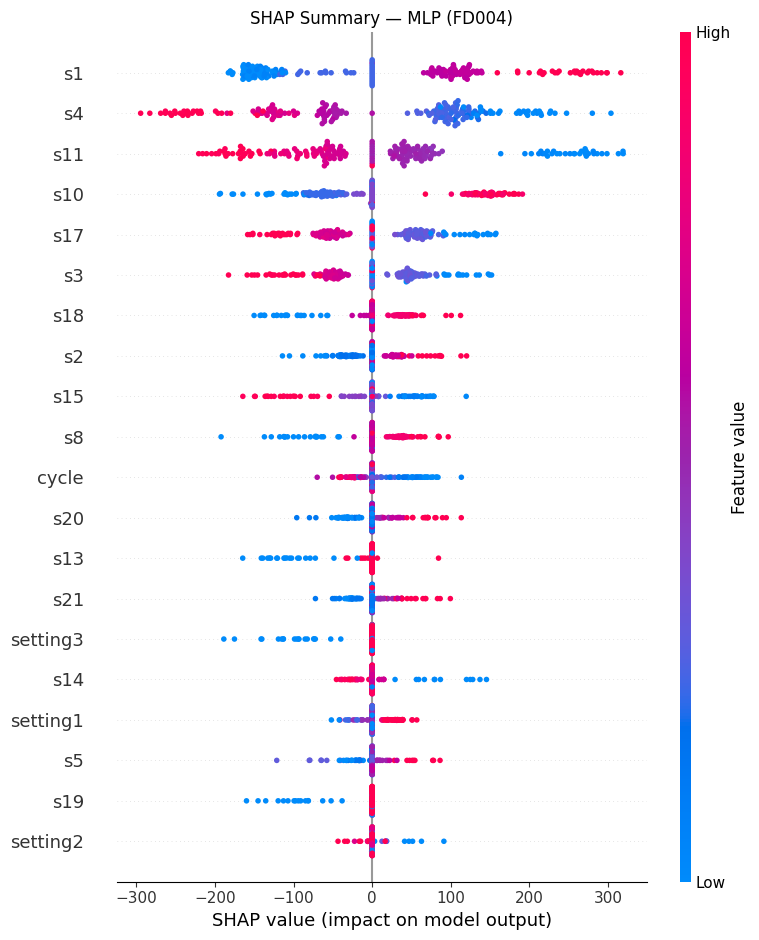

  0%|          | 0/1 [00:00<?, ?it/s]

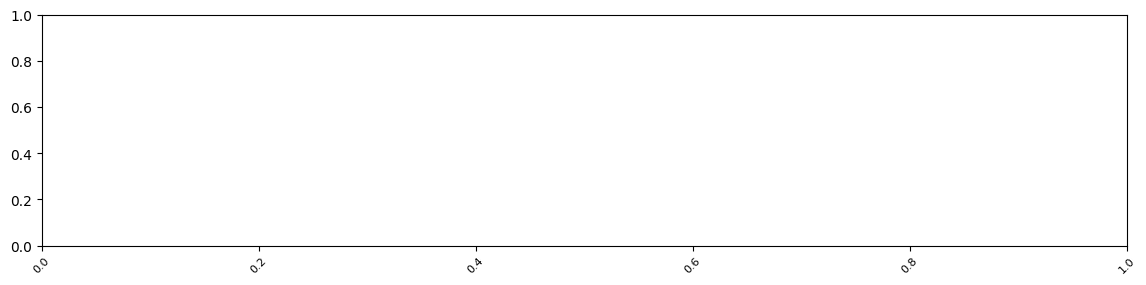

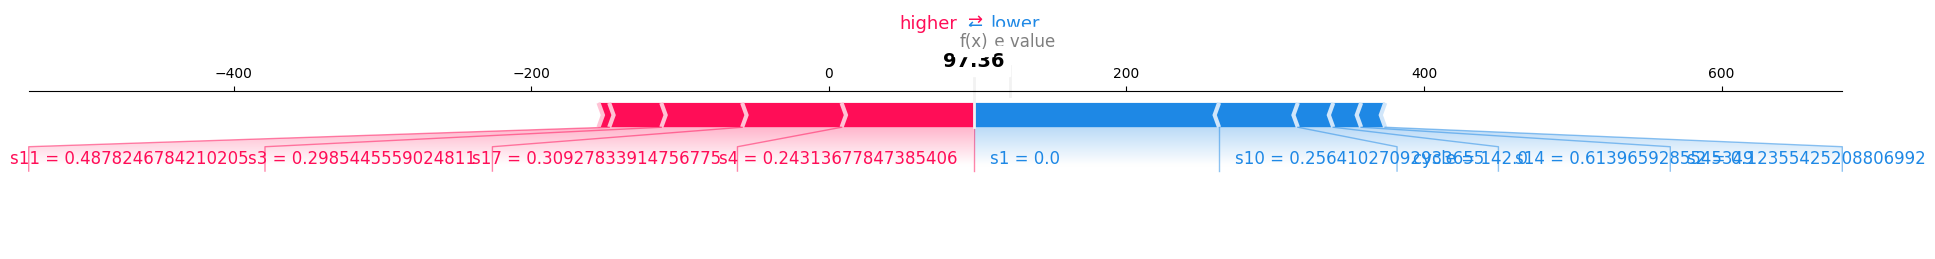

Plotting SHAP summary (Ensemble)...


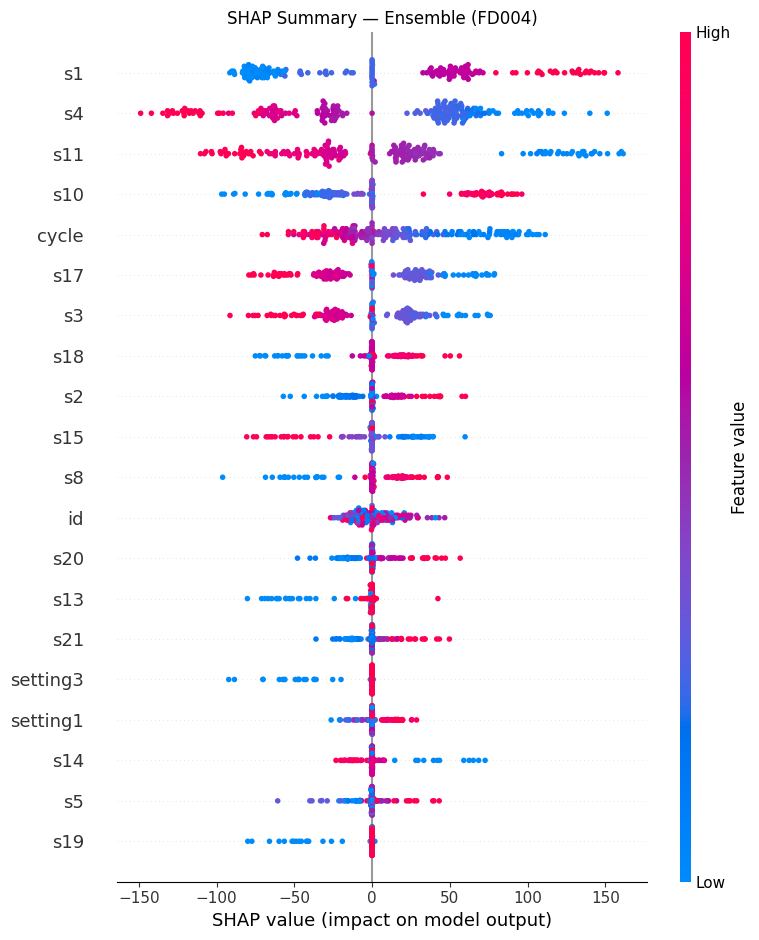

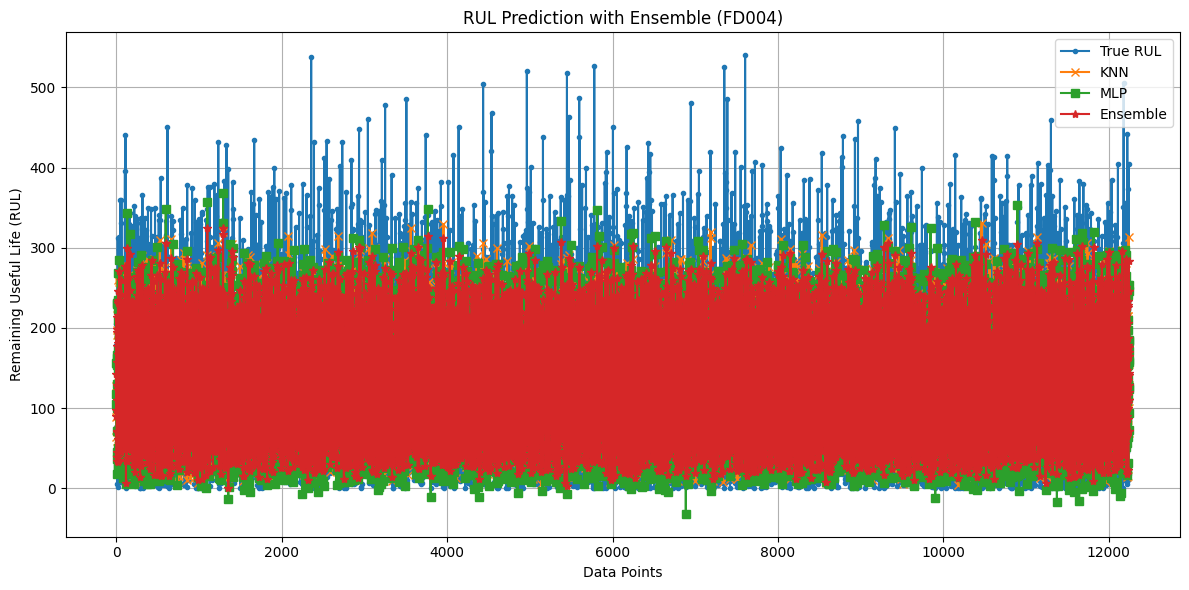



================ TIME-SERIES VALIDATION ADD-ONS ================

[CONFIG] Window(W)=30, Horizon(H)=1, Embargo=10, Splits=5
[CONFIG] Feature count=24

[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)

--- GroupKFold (KNN) ---
Fold1: R2=0.4757, RMSE=67.1677, MAE=47.1945, PHM08_sum=1377566919576.6636, PHM08_avg=112179716.5779
Fold2: R2=0.5825, RMSE=58.1009, MAE=40.6598, PHM08_sum=67283271310.0193, PHM08_avg=5539541.5207
Fold3: R2=0.5736, RMSE=58.0423, MAE=42.9607, PHM08_sum=1346145835132.8223, PHM08_avg=109683519.5252
Fold4: R2=0.6207, RMSE=54.5940, MAE=40.9302, PHM08_sum=4076393364.9276, PHM08_avg=332116.1288
Fold5: R2=0.6081, RMSE=55.4763, MAE=41.4788, PHM08_sum=443858750.9163, PHM08_avg=36156.6268
Overall: R2=0.5704, RMSE=58.8483, MAE=42.6493, PHM08_sum=2795516278135.3491, PHM08_avg=45641827.2647

--- GroupKFold (MLP) ---
Fold1: R2=0.5150, RMSE=64.6034, MAE=44.4286, PHM08_sum=2166818838883.1340, PHM08_avg=176451045.5117
Fold2: R2=0.7011, RMSE=49.1591, MAE=35.3207,

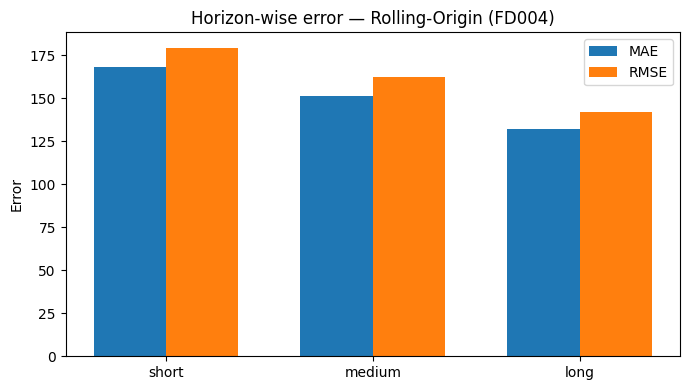

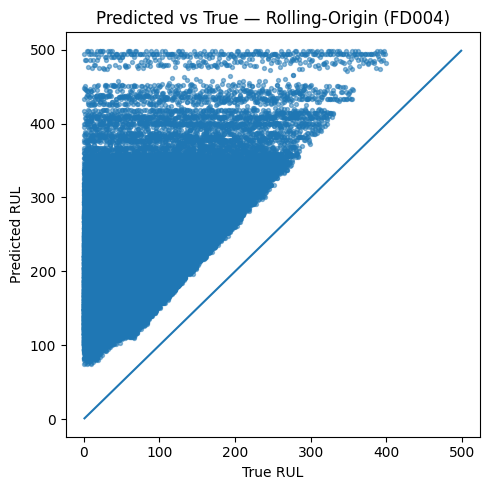


[PER-ENGINE MAE] (Top 10 worst engines)
118    268.101844
133    235.535470
179    226.130859
173    224.421076
49     220.388969
225    214.595465
158    205.580973
171    203.379721
164    195.569366
37     195.381624
dtype: float64


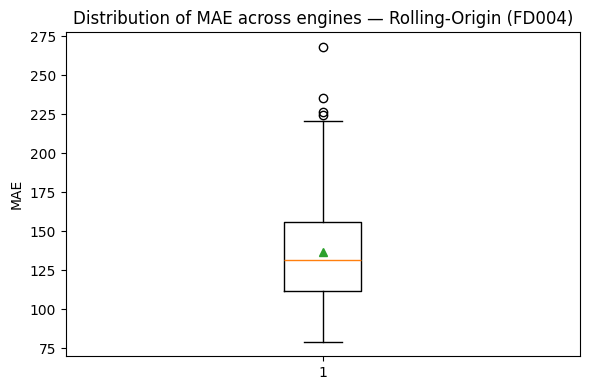

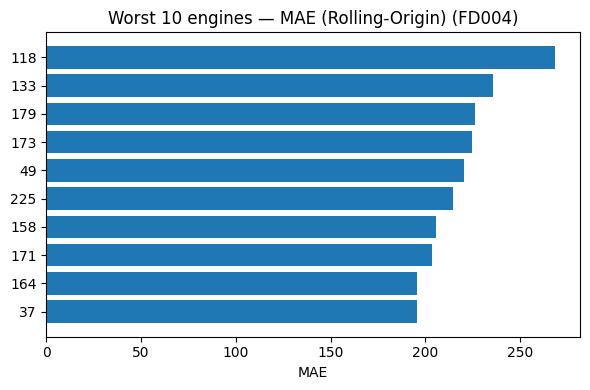


[ROLLING-ORIGIN OVERALL METRICS]
      R2: -7.0643
    RMSE: 159.6250
     MAE: 148.3875
 sMAPE_%: 114.0146

[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)
All features     : R²=0.5721 ± 0.0511
Without id/cycle : R²=0.5505 ± 0.0319


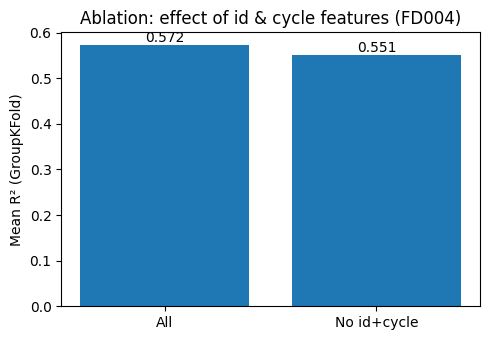


================ ROBUSTNESS ANALYSES COMPLETED ================


=== 80/20 SPLIT PROOF ===
Total samples : 61249
Train (80%)   : 48999  → ratio=0.8000
Test  (20%)   : 12250  → ratio=0.2000

=== RESOURCE USAGE REPORT ===
Elapsed time         : 2618.24 seconds
CPU% at start        : 4.2%   (~0.11 GHz)
CPU% at end          : 18.3%   (~0.47 GHz)
Memory at start      : 597.96 MB
Memory at end        : 608.32 MB   (Δ 10.36 MB)


In [5]:
# ============================================
# Configuration — choose CMAPSS subset once
# ============================================
# Set to "FD001", "FD002", "FD003", or "FD004"
DATASET_NAME = "FD004"

# Human-readable tag for the model family (used in output folder)
MODEL_TAG = "knnmlp"

# Fixed model hyperparameters (as requested)
KNN_PARAMS = dict(
    n_neighbors=14,
    weights='uniform',
    metric='manhattan'
)

MLP_PARAMS = dict(
    hidden_layer_sizes=(50, 50, 50),
    activation='relu',
    solver='adam',
    alpha=0.01,
    learning_rate='constant',
    max_iter=500,
    random_state=42
)

# ============================================
# Imports
# ============================================
import os
import time
import math
import psutil
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from pathlib import Path
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

warnings.filterwarnings("ignore")

# ============================================
# Output paths — single, unified directory
# ============================================
OUTPUT_DIR = Path(f"{MODEL_TAG}_{DATASET_NAME}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def save_png(filename: str, dpi: int = 200) -> None:
    name = Path(filename).name
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_DIR / name, dpi=dpi)

def save_txt(filename: str, text: str) -> None:
    name = Path(filename).name
    with open(OUTPUT_DIR / name, "w", encoding="utf-8") as f:
        f.write(text)

def save_df_csv(df: pd.DataFrame, filename: str) -> None:
    name = Path(filename).name
    df.to_csv(OUTPUT_DIR / name, index=False)

# ============================================
# Resource monitoring — lightweight snapshot
# ============================================
process = psutil.Process(os.getpid())

def human_mem(bytes_amt: int) -> str:
    return f"{bytes_amt/1024/1024:.2f} MB"

def human_ghz(ghz_amt: float) -> str:
    return f"{ghz_amt:.2f} GHz"

cpu_freq = psutil.cpu_freq()
max_mhz = cpu_freq.max if cpu_freq and cpu_freq.max and cpu_freq.max > 0 else cpu_freq.current

start_time      = time.time()
start_cpu_pct   = psutil.cpu_percent(interval=None)
start_mem_bytes = process.memory_info().rss
start_cpu_ghz   = start_cpu_pct/100 * (max_mhz / 1000.0)

# ============================================
# I/O — paths derived from DATASET_NAME
# ============================================
# NASA CMAPSS public data: https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data
train_path = f"train_{DATASET_NAME}.txt"
test_path  = f"test_{DATASET_NAME}.txt"
rul_path   = f"RUL_{DATASET_NAME}.txt"

# ============================================
# Load
# ============================================
train = pd.read_csv(train_path, sep=r'\s+', header=None)
test  = pd.read_csv(test_path,  sep=r'\s+', header=None)
y_test_file = pd.read_csv(rul_path, sep=r'\s+', header=None)

# ============================================
# Columns
# ============================================
columns = [
    'id','cycle','setting1','setting2','setting3',
    's1','s2','s3','s4','s5','s6','s7','s8','s9',
    's10','s11','s12','s13','s14','s15','s16',
    's17','s18','s19','s20','s21'
]
train.columns = columns
test.columns  = columns

# ============================================
# Sort & clean
# ============================================
train.sort_values(['id','cycle'], inplace=True)
test.sort_values(['id','cycle'], inplace=True)
y_test_file.dropna(axis=1, inplace=True)

# ============================================
# Compute training RUL
# ============================================
max_cycle_train = train.groupby('id')['cycle'].max().reset_index()
max_cycle_train.columns = ['id','max_cycle']
train = train.merge(max_cycle_train, on='id', how='left')
train['RUL'] = train['max_cycle'] - train['cycle']
train.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Normalize features (fit on train only)
# ============================================
features = train.columns.difference(['id','cycle','RUL'])
scaler = preprocessing.MinMaxScaler()
train_norm = pd.DataFrame(
    scaler.fit_transform(train[features]),
    columns=features, index=train.index
)
train = train[['id','cycle','RUL']].join(train_norm)

# ============================================
# Prepare test set (transform with train scaler)
# ============================================
test_norm = pd.DataFrame(
    scaler.transform(test[features]),
    columns=features, index=test.index
)
test = (
    test[test.columns.difference(features)]
    .join(test_norm)
    .reindex(columns=test.columns)
    .reset_index(drop=True)
)

# ============================================
# Compute test RUL from provided horizons
# ============================================
max_cycle_test = test.groupby('id')['cycle'].max().reset_index()
max_cycle_test.columns = ['id','max_cycle']
y_test_file.columns = ['collected_RUL']
y_test_file['id'] = y_test_file.index + 1
y_test_file['max_cycle'] = max_cycle_test['max_cycle'] + y_test_file['collected_RUL']
y_test_file.drop('collected_RUL', axis=1, inplace=True)
test = test.merge(y_test_file, on='id', how='left')
test['RUL'] = test['max_cycle'] - test['cycle']
test.drop('max_cycle', axis=1, inplace=True)

# ============================================
# Train/validation split
# ============================================
X = train.drop('RUL', axis=1)
y = train['RUL']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# ============================================
# Model training (KNN + MLP) and ensemble
# ============================================
knn_model = KNeighborsRegressor(**KNN_PARAMS)
knn_model.fit(X_train, y_train)
y_knn = knn_model.predict(X_val)

mlp_model = MLPRegressor(**MLP_PARAMS)
mlp_model.fit(X_train, y_train)
y_mlp = mlp_model.predict(X_val)

# Simple 2-model ensemble (equal weights)
y_ensemble = 0.5 * y_knn + 0.5 * y_mlp

# ============================================
# Metrics + PHM08
# ============================================
def phm08_score(y_true, y_pred):
    d = y_pred - np.asarray(y_true)
    return np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))

def print_block_metrics(name, y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    phm = phm08_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  R^2 Score:           {r2:.4f}")
    print(f"  Mean Squared Error:  {mse:.4f}")
    print(f"  Mean Absolute Error: {mae:.4f}")
    print(f"  PHM08 Score (sum):   {phm:.4f}")
    print(f"  PHM08 Score (avg):   {phm/len(y_true):.4f}")
    return {"model": name, "R2": r2, "MSE": mse, "MAE": mae, "PHM08_sum": phm, "PHM08_avg": phm/len(y_true)}

m_knn = print_block_metrics("KNN",         y_val, y_knn)
m_mlp = print_block_metrics("MLP",         y_val, y_mlp)
m_ens = print_block_metrics("Ensemble",    y_val, y_ensemble)

save_df_csv(pd.DataFrame([m_knn, m_mlp, m_ens]), f"holdout_metrics_{DATASET_NAME}.csv")

# ============================================
# SHAP explanations — KernelExplainer (model-agnostic)
# ============================================
# To keep runtime reasonable, we subsample background and explanation sets.
SHAP_MAX_SECS = 120
BG_KMEANS_K   = 25
EXPL_SAMPLES  = 200
NSAMPLES      = 100
L1_REG        = "num_features(10)"

bg_size   = min(1000, X_train.shape[0])
shap_size = min(EXPL_SAMPLES, X_val.shape[0])

X_bg_df   = X_train.sample(n=bg_size, random_state=42)
X_shap_df = X_val.sample(n=shap_size, random_state=42)

X_bg_np   = X_bg_df.to_numpy(dtype=np.float32)
X_shap_np = X_shap_df.to_numpy(dtype=np.float32)
feature_names = X.columns.tolist()

# Summarize background with k-means for performance
try:
    km_obj = shap.kmeans(X_bg_np, BG_KMEANS_K)
    X_bg_km = km_obj.data if hasattr(km_obj, "data") else np.array(km_obj)
except Exception as e:
    print(f"[WARN] kmeans background failed: {e}; using raw background.")
    X_bg_km = X_bg_np

def fast_kernel_shap(model, X_background_np, X_explain_np, X_explain_df, title_prefix, file_tag):
    import time as _time
    t0 = _time.time()

    # Ensure DenseData is converted to ndarray before prediction
    def predict_fn(A):
        if hasattr(A, "data"):
            A = A.data
        return model.predict(np.asarray(A, dtype=np.float32))

    try:
        explainer = shap.KernelExplainer(predict_fn, X_background_np, link="identity")
        shap_vals = explainer.shap_values(
            X_explain_np, nsamples=NSAMPLES, l1_reg=L1_REG
        )
        shap_vals = np.asarray(shap_vals)

        shap.summary_plot(shap_vals, X_explain_df, feature_names=feature_names, show=False)
        plt.title(f"SHAP Summary — {title_prefix} ({DATASET_NAME})")
        plt.tight_layout()
        save_png(f"SHAP_Summary_{file_tag}_{DATASET_NAME}.png")
        plt.show()

        row_np  = X_explain_np[[0]]
        sv_row  = np.asarray(explainer.shap_values(row_np, nsamples=NSAMPLES, l1_reg=L1_REG))[0]
        expected_val = float(np.mean(predict_fn(X_background_np)))
        fig, ax = plt.subplots(figsize=(14, 3))
        _ = shap.force_plot(expected_val, sv_row, row_np[0],
                            feature_names=feature_names, matplotlib=True, show=False)
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        plt.tight_layout()
        save_png(f"Local_SHAP_force_{file_tag}_Single_{DATASET_NAME}.png")
        plt.show()

        if (_time.time() - t0) > SHAP_MAX_SECS:
            print(f"[INFO] {title_prefix} SHAP exceeded time cap.")

        return shap_vals

    except Exception as e:
        print(f"[WARN] {title_prefix} SHAP failed: {e}")
        return None

print("Computing SHAP (fast mode) for KNN...")
shap_vals_knn = fast_kernel_shap(knn_model, X_bg_km, X_shap_np, X_shap_df, "KNN", "KNN")

print("Computing SHAP (fast mode) for MLP...")
shap_vals_mlp = fast_kernel_shap(mlp_model, X_bg_km, X_shap_np, X_shap_df, "MLP", "MLP")

if (shap_vals_knn is not None) and (shap_vals_mlp is not None) and \
   (np.shape(shap_vals_knn) == np.shape(shap_vals_mlp)):
    shap_vals_ens = (np.asarray(shap_vals_knn) + np.asarray(shap_vals_mlp)) / 2.0
    print("Plotting SHAP summary (Ensemble)...")
    shap.summary_plot(shap_vals_ens, X_shap_df, feature_names=feature_names, show=False)
    plt.title(f"SHAP Summary — Ensemble ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"SHAP_Summary_Ensemble_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] Ensemble SHAP skipped (inputs unavailable or shape mismatch).")

# ============================================
# Prediction plot
# ============================================
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_val)),      y_val.values,   label="True RUL",  marker='.')
plt.plot(range(len(y_knn)),      y_knn,          label="KNN",       marker='x')
plt.plot(range(len(y_mlp)),      y_mlp,          label="MLP",       marker='s')
plt.plot(range(len(y_ensemble)), y_ensemble,     label="Ensemble",  marker='*')
plt.xlabel("Data Points")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title(f"RUL Prediction with Ensemble ({DATASET_NAME})")
plt.legend()
plt.grid(True)
plt.tight_layout()
save_png(f"RUL_Prediction_with_Ensemble_{DATASET_NAME}.png")
plt.show()

# ================================
# === TIME-SERIES VALIDATION ADD-ONS ===
# ================================
print("\n\n================ TIME-SERIES VALIDATION ADD-ONS ================\n")

# Config & helpers
W = 30
H = 1
EMBARGO = 10
N_SPLITS = 5

ENGINE_COL = "id"
TIME_COL   = "cycle"
TARGET_COL = "RUL"

ALL_FEATURES = [c for c in train.columns if c not in [ENGINE_COL, TIME_COL, TARGET_COL]]
print(f"[CONFIG] Window(W)={W}, Horizon(H)={H}, Embargo={EMBARGO}, Splits={N_SPLITS}")
print(f"[CONFIG] Feature count={len(ALL_FEATURES)}")

def ts_metrics(y_true, y_pred, prefix=""):
    r2  = r2_score(y_true, y_pred)
    rmse= np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    d   = y_pred - np.asarray(y_true)
    phm = np.sum(np.where(d < 0, np.exp(-d/13) - 1, np.exp(d/10) - 1))
    return {
        f"{prefix}R2": r2,
        f"{prefix}RMSE": rmse,
        f"{prefix}MAE": mae,
        f"{prefix}PHM08_sum": phm,
        f"{prefix}PHM08_avg": phm/len(y_true)
    }

METRIC_ORDER = ["R2", "RMSE", "MAE", "PHM08_sum", "PHM08_avg"]

def _row_prefix(d):
    return sorted({k.split("_")[0] for k in d.keys()})[0] if d else "Row"

def print_metrics_compact(rows, title="Metrics"):
    print(f"\n--- {title} ---")
    for d in rows:
        pref = _row_prefix(d)
        parts = []
        for m in METRIC_ORDER:
            k = f"{pref}_{m}"
            if k in d:
                parts.append(f"{m}={d[k]:.4f}")
        print(f"{pref}: " + (", ".join(parts) if parts else "(no metrics)"))

print_metrics_table = print_metrics_compact

# Scenario A — Group-aware CV (engine-wise), fold-internal scaling
print("\n[SCENARIO A] Group-aware CV with fold-internal scaling (GroupKFold)")
gkf = GroupKFold(n_splits=5)

pipe_knn = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", KNeighborsRegressor(**KNN_PARAMS))
])
pipe_mlp = Pipeline([
    ("scaler", MinMaxScaler()),
    ("model", MLPRegressor(**MLP_PARAMS))
])

def cv_eval_pipeline(X_df, y_series, groups, pipeline, name="Model"):
    rows = []
    all_y, all_p = [], []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(pipeline).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"Fold{k}_"))
        all_y.append(y_va.values); all_p.append(p)
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"GroupKFold ({name})")
    return overall

groups = X[ENGINE_COL] if ENGINE_COL in X.columns else train[ENGINE_COL].loc[X.index]
_ = cv_eval_pipeline(X, y, groups, pipe_knn, name="KNN")
_ = cv_eval_pipeline(X, y, groups, pipe_mlp, name="MLP")

# Scenario B — Rolling-Origin Backtest with Purge + Embargo (per engine)
print("\n[SCENARIO B] Rolling-Origin Backtest with Purge + Embargo (per engine)")

def rolling_origin_splits_per_engine(df_engine, n_splits=N_SPLITS, window=W, horizon=H, embargo=EMBARGO):
    g = df_engine.sort_values(TIME_COL).reset_index()
    T = len(g)
    if T <= (window + horizon + 1):
        return []
    cuts = np.linspace(window + horizon, T - horizon, num=n_splits+1, dtype=int)[1:]
    splits = []
    for cut in cuts:
        train_end  = max(window, cut - (window - 1))
        test_start = min(T - horizon, cut + embargo)
        if test_start <= train_end or test_start >= T - horizon:
            continue
        tr_idx = g.loc[:train_end-1, "index"].values
        te_idx = g.loc[test_start:T - horizon - 1, "index"].values
        if len(te_idx) == 0 or len(tr_idx) == 0:
            continue
        splits.append((tr_idx, te_idx))
    return splits

def rolling_origin_backtest(df_all, features, model_builder, name="Model"):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No rolling-origin folds produced (data too short or config too strict).")
        return None
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix="Overall_")
    print_metrics_table(rows + [overall], title=f"Rolling-Origin ({name})")
    return overall

def build_pipe_knn():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", KNeighborsRegressor(**KNN_PARAMS))
    ])

def build_pipe_mlp():
    return Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", MLPRegressor(**MLP_PARAMS))
    ])

_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_knn, name="KNN"
)
_ = rolling_origin_backtest(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_mlp, name="MLP"
)

# ============================================
# A/B leakage diagnostics
# ============================================
print("\n[AB TESTS] Leakage/Sensitivity Experiments")

def random_split_eval(X_df, y_series, model_builder, name="Model"):
    X_tr, X_va, y_tr, y_va = train_test_split(
        X_df, y_series, test_size=0.2, random_state=42, shuffle=True
    )
    mdl = model_builder()
    mdl.fit(X_tr, y_tr)
    p = mdl.predict(X_va)
    m = ts_metrics(y_va, p, prefix="Random80/20_")
    print_metrics_table([m], title=f"Random 80/20 ({name})")
    return m

def global_scaler_vs_fold_scaler(X_df, y_series, groups):
    mdl_global = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", KNeighborsRegressor(**KNN_PARAMS))
    ])
    mdl_fold = Pipeline([
        ("scaler", MinMaxScaler()),
        ("model", KNeighborsRegressor(**KNN_PARAMS))
    ])
    scaler_glob = MinMaxScaler().fit(X_df)
    X_glob = pd.DataFrame(scaler_glob.transform(X_df), columns=X_df.columns, index=X_df.index)

    rows = []
    for k, (tr, va) in enumerate(gkf.split(X_glob, y_series, groups=groups), 1):
        X_tr, X_va = X_glob.iloc[tr], X_glob.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_global).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows.append(ts_metrics(y_va, p, prefix=f"GlobalScaler_Fold{k}_"))
    print_metrics_table(rows, title="GroupKFold with Global Scaler (potentially optimistic)")

    rows2 = []
    for k, (tr, va) in enumerate(gkf.split(X_df, y_series, groups=groups), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y_series.iloc[tr], y_series.iloc[va]
        mdl = clone(mdl_fold).fit(X_tr, y_tr)
        p = mdl.predict(X_va)
        rows2.append(ts_metrics(y_va, p, prefix=f"FoldScaler_Fold{k}_"))
    print_metrics_table(rows2, title="GroupKFold with Fold-Internal Scaler (safer)")

print("[AB] Random 80/20 vs GroupKFold vs Rolling-Origin")
_ = random_split_eval(X, y, build_pipe_knn, name="KNN")
_ = cv_eval_pipeline(X, y, groups, build_pipe_knn(), name="KNN (GroupKFold)")

print("\n[AB] Global scaler vs Fold-internal scaler (GroupKFold)")
global_scaler_vs_fold_scaler(X, y, groups)

print("\n[AB] Embargo sensitivity (0 vs 10)")
def rolling_origin_backtest_with_embargo(df_all, features, model_builder, embargo_val, name):
    rows, all_y, all_p = [], [], []
    fold_id = 0
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        g = df_e.sort_values(TIME_COL).reset_index()
        T = len(g)
        cuts = np.linspace(W + H, T - H, num=N_SPLITS+1, dtype=int)[1:]
        for cut in cuts:
            train_end  = max(W, cut - (W - 1))
            test_start = min(T - H, cut + embargo_val)
            if test_start <= train_end or test_start >= T - H:
                continue
            tr_idx = g.loc[:train_end-1, "index"].values
            te_idx = g.loc[test_start:T - H - 1, "index"].values
            if len(te_idx) == 0 or len(tr_idx) == 0:
                continue
            fold_id += 1
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            rows.append(ts_metrics(y_te, p, prefix=f"Fold{fold_id}_"))
            all_y.append(y_te.values); all_p.append(p)
    if not rows:
        print("[WARN] No folds created in embargo sensitivity run.")
        return
    all_y = np.concatenate(all_y); all_p = np.concatenate(all_p)
    overall = ts_metrics(all_y, all_p, prefix=f"Overall_")
    print_metrics_table(rows + [overall], title=name)

rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_knn,
    embargo_val=0,  name=f"Rolling-Origin KNN (Embargo=0, {DATASET_NAME})"
)
rolling_origin_backtest_with_embargo(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_knn,
    embargo_val=10, name=f"Rolling-Origin KNN (Embargo=10, {DATASET_NAME})"
)

# ============================================
# Permutation (Null) Test
# ============================================
print("\n[NULL MODEL] In-engine label permutation to detect leakage")

def one_rolling_origin_preds(df_all, features, model_builder):
    ys, ps = [], []
    for _, df_e in df_all.groupby(ENGINE_COL, sort=False):
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            ys.append(y_te.values); ps.append(p)
    if not ys:
        return None, None
    return np.concatenate(ys), np.concatenate(ps)

def permutation_test_in_engine(df_all, features, model_builder, n_iters=1):
    rng = np.random.default_rng(42)
    for it in range(n_iters):
        df_perm = df_all.copy()
        df_perm[TARGET_COL] = (
            df_perm.groupby(ENGINE_COL)[TARGET_COL]
                  .transform(lambda s: s.values[rng.permutation(len(s))])
        )
        _ = rolling_origin_backtest(
            df_perm[[ENGINE_COL, TIME_COL, TARGET_COL] + features],
            features, model_builder, name=f"Null-It{it+1}"
        )
    print("[INFO] Null-model results above; R2 should be ~0 (or negative).")

permutation_test_in_engine(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_knn, n_iters=1
)

# ============================================
# Horizon-wise error profile & plots
# ============================================
print("\n[HORIZON-WISE ERROR] Binned by RUL ranges (short/medium/long)")

def horizon_bins(y_rul):
    bins = [-np.inf, 25, 75, np.inf]
    labels = ["short", "medium", "long"]
    return pd.cut(y_rul, bins=bins, labels=labels)

hy, hp = one_rolling_origin_preds(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_knn
)

if hy is not None:
    dfm = pd.DataFrame({"y": hy, "p": hp, "bin": horizon_bins(pd.Series(hy))})
    met = (dfm.groupby("bin", dropna=False)
             .apply(lambda g: pd.Series({
                 "MAE": mean_absolute_error(g["y"], g["p"]),
                 "RMSE": np.sqrt(mean_squared_error(g["y"], g["p"])),
                 "R2": r2_score(g["y"], g["p"])
             }))
          ).reset_index()
    print("\n[HORIZON-WISE ERROR] (Table)")
    print(met)
    save_df_csv(met, f"horizon_wise_error_table_{DATASET_NAME}.csv")

    plt.figure(figsize=(7,4))
    idx = np.arange(len(met)); w = 0.35
    plt.bar(idx - w/2, met["MAE"].values, width=w, label="MAE")
    plt.bar(idx + w/2, met["RMSE"].values, width=w, label="RMSE")
    plt.xticks(idx, met["bin"].astype(str))
    plt.ylabel("Error")
    plt.title(f"Horizon-wise error — Rolling-Origin ({DATASET_NAME})")
    plt.legend()
    plt.tight_layout()
    save_png(f"horizon_wise_errors_{DATASET_NAME}.png")
    plt.show()

    plt.figure(figsize=(5,5))
    lo = float(min(np.min(hy), np.min(hp))); hi = float(max(np.max(hy), np.max(hp)))
    plt.scatter(hy, hp, s=8, alpha=0.5)
    plt.plot([lo, hi], [lo, hi])
    plt.xlabel("True RUL")
    plt.ylabel("Predicted RUL")
    plt.title(f"Predicted vs True — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"scatter_pred_vs_true_rolling_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] Horizon-wise error plot skipped (no rolling-origin predictions available).")

# ============================================
# Per-engine error distribution
# ============================================
def rolling_origin_engine_errors(df_all, features, model_builder):
    per_engine_abs_errors = {}
    for eid, df_e in df_all.groupby(ENGINE_COL, sort=False):
        errs = []
        for (tr_idx, te_idx) in rolling_origin_splits_per_engine(df_e):
            X_tr = df_all.loc[tr_idx, features]; y_tr = df_all.loc[tr_idx, TARGET_COL]
            X_te = df_all.loc[te_idx, features]; y_te = df_all.loc[te_idx, TARGET_COL]
            mdl = model_builder(); mdl.fit(X_tr, y_tr)
            p = mdl.predict(X_te)
            errs.append(np.abs(y_te.values - p))
        if errs:
            per_engine_abs_errors[eid] = np.concatenate(errs)
    return per_engine_abs_errors

per_engine = rolling_origin_engine_errors(
    train[[ENGINE_COL, TIME_COL, TARGET_COL] + ALL_FEATURES],
    ALL_FEATURES, build_pipe_knn
)

if per_engine:
    mae_series = pd.Series(
        {eid: np.mean(v) for eid, v in per_engine.items()}
    ).sort_values(ascending=False)
    print("\n[PER-ENGINE MAE] (Top 10 worst engines)")
    print(mae_series.head(10))
    mae_df = mae_series.rename_axis("engine_id").reset_index(name="MAE")
    save_df_csv(mae_df, f"per_engine_mae_{DATASET_NAME}.csv")

    plt.figure(figsize=(6,4))
    plt.boxplot(mae_series.values, vert=True, showmeans=True)
    plt.ylabel("MAE")
    plt.title(f"Distribution of MAE across engines — Rolling-Origin ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"box_engine_mae_rolling_{DATASET_NAME}.png")
    plt.show()

    topk = mae_series.head(10)[::-1]
    plt.figure(figsize=(6,4))
    plt.barh(topk.index.astype(str), topk.values)
    plt.xlabel("MAE")
    plt.title(f"Worst 10 engines — MAE (Rolling-Origin) ({DATASET_NAME})")
    plt.tight_layout()
    save_png(f"top_engines_mae_barh_{DATASET_NAME}.png")
    plt.show()
else:
    print("[WARN] No per-engine error analysis results were produced.")

# ============================================
# sMAPE + overall rolling-origin metrics
# ============================================
def smape(a, f):
    a = np.asarray(a); f = np.asarray(f)
    den = (np.abs(a) + np.abs(f))
    den[den == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(f - a) / den)

if hy is not None:
    overall = {
        "R2": r2_score(hy, hp),
        "RMSE": np.sqrt(mean_squared_error(hy, hp)),
        "MAE": mean_absolute_error(hy, hp),
        "sMAPE_%": smape(hy, hp),
    }
    print("\n[ROLLING-ORIGIN OVERALL METRICS]")
    for k, v in overall.items():
        print(f"{k:>8}: {v:.4f}")
    save_df_csv(pd.DataFrame([overall]), f"rolling_origin_overall_metrics_{DATASET_NAME}.csv")

# ============================================
# Ablation: effect of including id & cycle
# ============================================
print("\n[ABLATION] Comparing with/without 'id' and 'cycle' features (GroupKFold R²)")

def cv_r2_mean(X_df, y_series, groups, pipe_builder):
    scores = []
    for tr, va in gkf.split(X_df, y_series, groups=groups):
        mdl = pipe_builder()
        mdl.fit(X_df.iloc[tr], y_series.iloc[tr])
        p = mdl.predict(X_df.iloc[va])
        scores.append(r2_score(y_series.iloc[va], p))
    return np.mean(scores), np.std(scores)

r2_all_mean, r2_all_std = cv_r2_mean(X, y, groups, build_pipe_knn)

drop_cols = [c for c in ["id", "cycle"] if c in X.columns]
if drop_cols:
    X_no_ic = X.drop(columns=drop_cols)
    groups_no_ic = groups.loc[X_no_ic.index] if hasattr(groups, "loc") else groups
    r2_noic_mean, r2_noic_std = cv_r2_mean(X_no_ic, y, groups_no_ic, build_pipe_knn)
    print(f"All features     : R²={r2_all_mean:.4f} ± {r2_all_std:.4f}")
    print(f"Without id/cycle : R²={r2_noic_mean:.4f} ± {r2_noic_std:.4f}")

    plt.figure(figsize=(5,3.5))
    labs = ["All", "No id+cycle"]
    vals = [r2_all_mean, r2_noic_mean]
    plt.bar(labs, vals)
    plt.ylabel("Mean R² (GroupKFold)")
    plt.title(f"Ablation: effect of id & cycle features ({DATASET_NAME})")
    for i, v in enumerate(vals):
        plt.text(i, v, f"{v:.3f}", ha="center", va="bottom")
    plt.tight_layout()
    save_png(f"ablation_id_cycle_{DATASET_NAME}.png")
    plt.show()
else:
    print("[INFO] 'id' and/or 'cycle' not found in X; skipping ablation.")

print("\n================ ROBUSTNESS ANALYSES COMPLETED ================\n")

# ============================================
# 80/20 split verification (and persist)
# ============================================
RANDOM_STATE = 42
TEST_SIZE = 0.20

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

n_tr, n_te = len(X_tr), len(X_te)
n_all = n_tr + n_te
p_test = n_te / n_all
p_train = n_tr / n_all

assert math.isclose(p_test, TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected test ratio {TEST_SIZE*100:.1f}%, got {p_test*100:.3f}%"
assert math.isclose(p_train, 1 - TEST_SIZE, rel_tol=0, abs_tol=5e-4), \
    f"Expected train ratio {(1-TEST_SIZE)*100:.1f}%, got {p_train*100:.3f}%"

print("\n=== 80/20 SPLIT PROOF ===")
print(f"Total samples : {n_all}")
print(f"Train (80%)   : {n_tr}  → ratio={p_train:.4f}")
print(f"Test  (20%)   : {n_te}  → ratio={p_test:.4f}")

proof_txt = f"""=== 80/20 SPLIT PROOF ===
Total samples : {n_all}
Train count   : {n_tr}  (ratio={p_train:.6f})
Test count    : {n_te}  (ratio={p_test:.6f})
"""
save_txt(f"split_80_20_proof_{DATASET_NAME}.txt", proof_txt)

split_counts = pd.DataFrame(
    {"set": ["train", "test"], "count": [n_tr, n_te], "ratio": [p_train, p_test]}
)
save_df_csv(split_counts, f"split_80_20_counts_{DATASET_NAME}.csv")

# ============================================
# Resource usage tail report
# ============================================
end_time      = time.time()
end_cpu_pct   = psutil.cpu_percent(interval=None)
end_mem_bytes = process.memory_info().rss
end_cpu_ghz   = end_cpu_pct/100 * (max_mhz / 1000.0)

print("\n=== RESOURCE USAGE REPORT ===")
print(f"Elapsed time         : {end_time - start_time:.2f} seconds")
print(f"CPU% at start        : {start_cpu_pct:.1f}%   (~{human_ghz(start_cpu_ghz)})")
print(f"CPU% at end          : {end_cpu_pct:.1f}%   (~{human_ghz(end_cpu_ghz)})")
print(f"Memory at start      : {human_mem(start_mem_bytes)}")
print(f"Memory at end        : {human_mem(end_mem_bytes)}   (Δ {human_mem(end_mem_bytes - start_mem_bytes)})")
